<a href="https://colab.research.google.com/github/yashchauhan2910/Geoscience-with-Integrated-Data-Science---Heriot-Watt/blob/main/Classification_Algorithms_for_Well_Data_Yash_Singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
created by **Farah Rabie** (f.rabie@hw.ac.uk)
***

#### Introduction

<p>This notebook focuses on classifying well log data to predict lithology from measured geophysical properties. Two machine learning algorithms are tested for this task: </p>
<ul>
    <li><code>K-Nearest Neighbours</code> - a method that classifies data points based on the majority class of their nearest neighbours.</li>
    <li><code>Random Forest</code> - a method that builds multiple decision trees and combines their predictions. </li>    
</ul>

Video tutorials covering this notebook are available here:  
- [Data Processing](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-1.mp4)  
- [K-Nearest Neighbours](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-2.mp4)  
- [Random Forest](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-3.mp4)

Let's get started! First, let's clone the repository to access the data and modules needed for this notebook.

In [4]:
!git clone https://github.com/farah-rabie/GeosciencePlusAI.git

Cloning into 'GeosciencePlusAI'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 749 (delta 152), reused 108 (delta 108), pack-reused 577 (from 3)
Receiving objects: 100% (749/749), 131.72 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (425/425), done.
Updating files: 100% (53/53), done.


##### I$\,\,\,\,\,\,$Data Processing for Classification

To start, define the file paths for the training, validation, and test well log datasets.

In [8]:
# List of wells:
#"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-11 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-12.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-14.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"

train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-15 C.csv",
                       "/content/GeosciencePlusAI/Data/15_9-F-1 B.csv","/content/GeosciencePlusAI/Data/15_9-F-14.csv"
                        ]
val_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-12.csv","/content/GeosciencePlusAI/Data/15_9-F-11 B.csv"]

test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv","/content/GeosciencePlusAI/Data/15_9-F-4.csv"]

Next, load the prepackaged data processing functions.  

This provides ready-made functions to visualise, clean, and scale the well log datasets.

In [9]:
from GeosciencePlusAI.Lib.ClassificationFunctions import DataProcessing
DataProcess = DataProcessing()

<p>Before processing the data, we visualise the lithology distribution across wells.  

This helps us understand the dataset structure and identify potential issues, such as class imbalances where some lithologies are under-represented.</p>

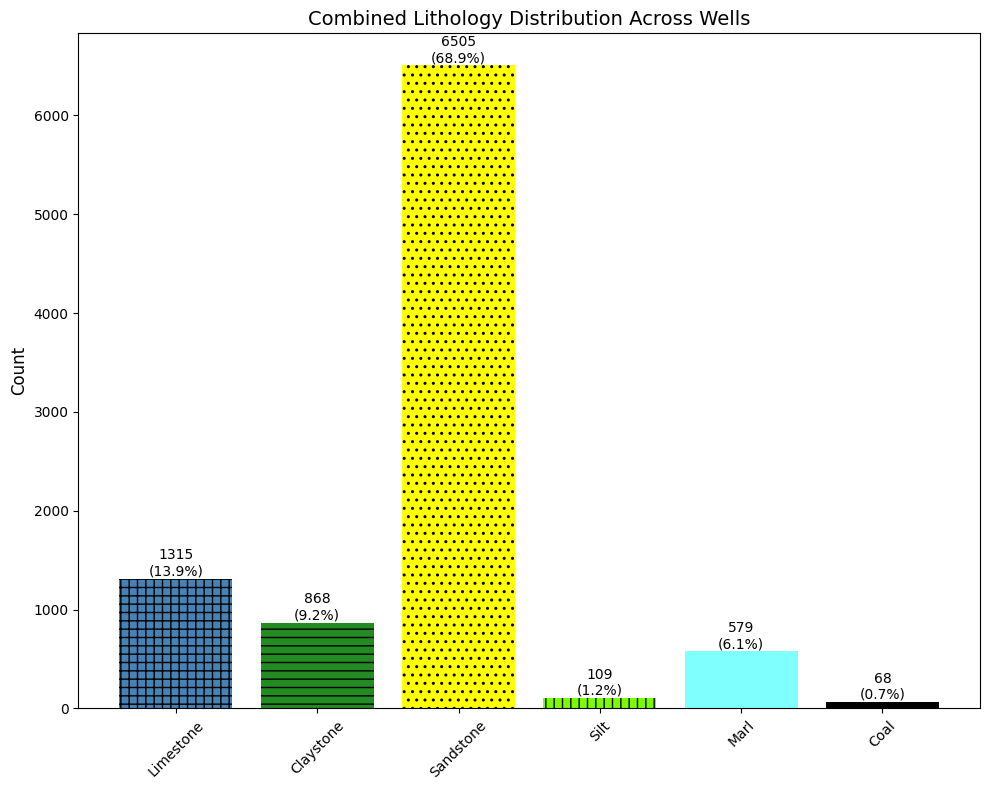

In [10]:
DataProcess.visualise_lithology_distribution(train_well_data_path, display = 'both')
# The (display='both') option shows the lithology distribution as both counts and percentages.
# You can also choose 'count' or 'percentage' to display only one of these. By default, display is set to count.

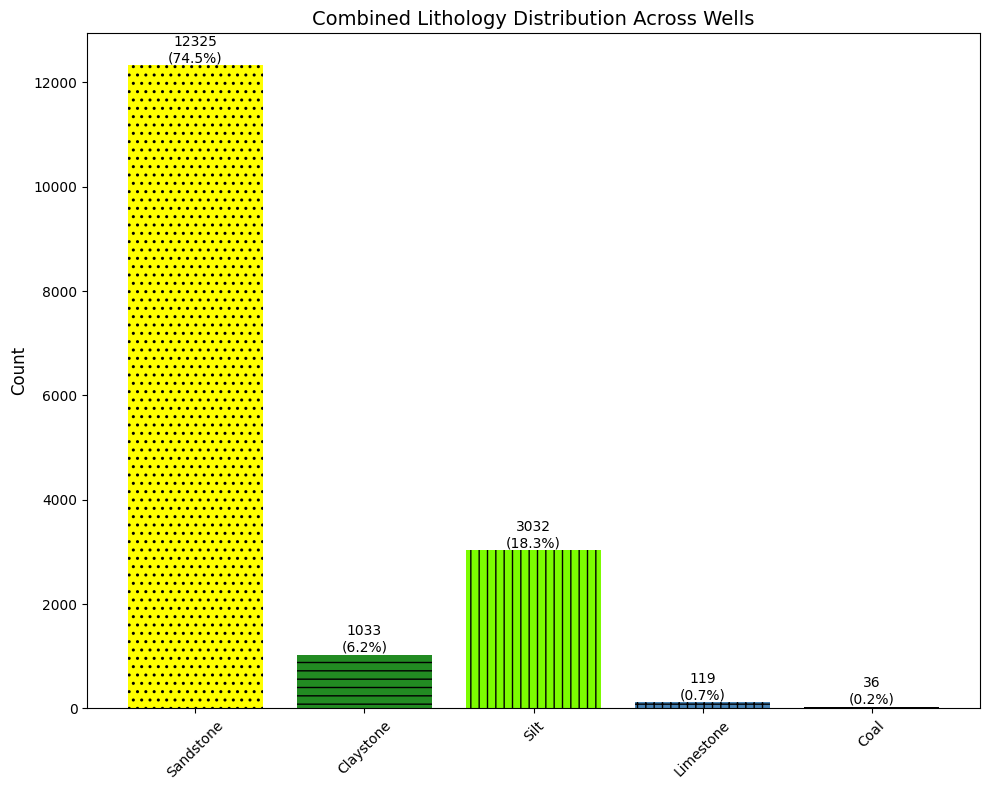

In [11]:
DataProcess.visualise_lithology_distribution(val_well_data_path, display = 'both')

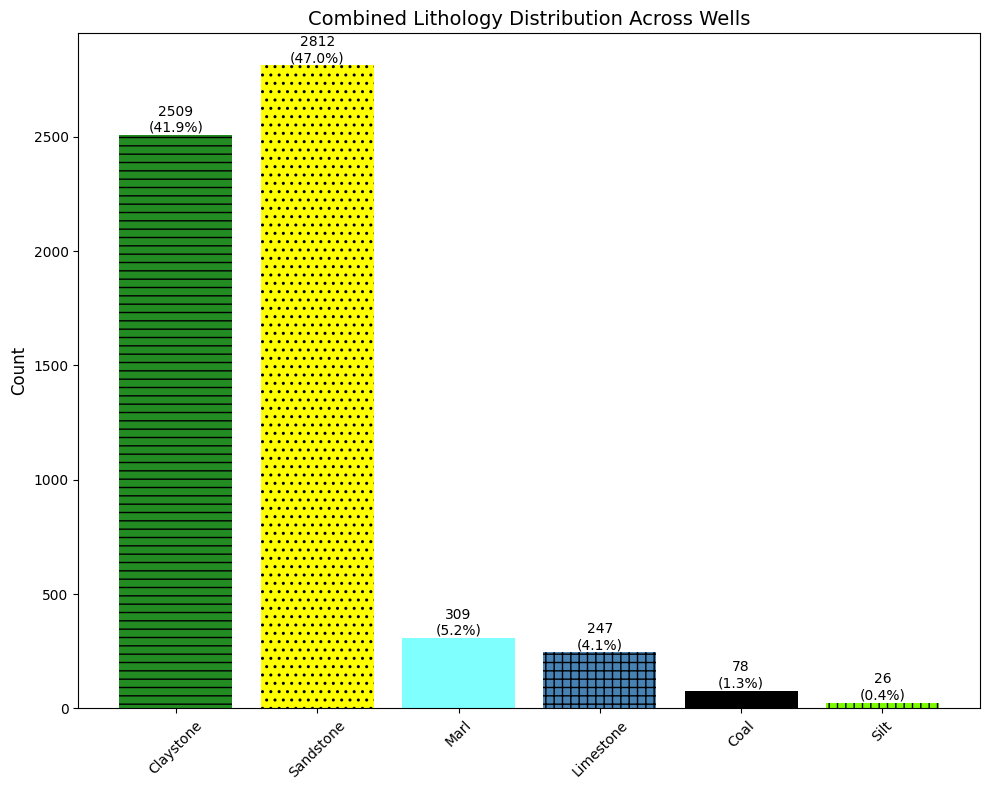

In [12]:
DataProcess.visualise_lithology_distribution(test_well_data_path, display = 'both')

After visualising the lithology distribution and highlighting potential issues, the next step is to process the data.

Processing cleans and transforms the data into a format suitable for training machine learning algorithms.

The `process_well_data` function performs several key steps:

- Handles missing values.  
- Removes invalid points (values outside a specified range can be excluded).  
- Replaces original permeability and resistivity columns (`KLOGH` and `RT`) with their log-transformed versions.
- Computes scaling parameters using the training dataset.

First, select the relevant columns from the datasets for training, validation, and testing.

In [13]:
selected_columns_train = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded
selected_columns_val = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded
selected_columns_test = ['DEPTH', 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded ('DEPTH' is included for visualisation purposes)

Next, process the training well data using the selected columns.  

In [14]:
processed_train_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_train, method = 'standard', train_data = True, show_stats = True)

# The `method` parameter determines how the data will be scaled:
##   `standard` - transforms features to have a mean of 0 and a standard deviation of 1. Useful when the data roughly follows a Gaussian distribution.
##   `minmax_01` - scales features to the range [0, 1]. Useful when values need to be strictly positive or within a fixed range.
##   `minmax_11` - scales features to the range [-1, 1]. Often used in neural networks, especially when activation functions like tanh are applied.


Descriptive Statistics of Data:
               BVW          VSH           GR         NPHI         RHOB  \
count  9317.000000  9317.000000  9317.000000  9317.000000  9317.000000   
mean      0.058676     0.313790    41.946646     0.171867     2.384786   
std       0.067788     0.153548    17.872850     0.047873     0.162958   
min       0.000000     0.000000     5.616400     0.000000     1.429500   
25%       0.030300     0.210400    29.812700     0.144500     2.233400   
50%       0.044800     0.309300    42.275700     0.173800     2.375400   
75%       0.076200     0.387800    51.499001     0.200200     2.530500   
max       1.000000     1.000000   148.377502     0.482200     3.051700   

         log_KLOGH       log_RT  
count  9317.000000  9317.000000  
mean      2.235692     2.478667  
std       2.414897     1.783194  
min       0.000000     0.107598  
25%       0.086820     1.088394  
50%       1.374146     1.847084  
75%       3.878278     3.388781  
max      11.186140     8.517

Using the same function, process the validation and test data (using selected columns).

In [15]:
processed_val_well_data = DataProcess.process_well_data(val_well_data_path, selected_columns_val, method = 'standard', val_data = True)

In [16]:
processed_test_well_data = DataProcess.process_well_data(test_well_data_path, selected_columns_test, show_stats=False)

<p> Now, we scale the three datasets. When all numerical features are on the same scale, no single feature dominates due to its scale.
<p> To apply a specific scaling method, we can pass it as a parameter when computing the scaling parameters. For example, to standardise, we include <code>method='standard'</code> in <code>process_well_data</code>.</p>

In [17]:
scaled_train_well_data = DataProcess.scale_dataframe(processed_train_well_data, show_stats= True)
# with show_stats = True >> allows us to confirm that the standardisation parameters are kept constant.


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.05867606526639477, 'std': 0.06778823644916658}
VSH: {'mean': 0.3137895782127294, 'std': 0.1535476675524408}
GR: {'mean': 41.94664639545627, 'std': 17.872849996498587}
NPHI: {'mean': 0.17186742514135453, 'std': 0.047872602417781955}
RHOB: {'mean': 2.384785521655576, 'std': 0.16295783588534604}
log_KLOGH: {'mean': 2.235691629316863, 'std': 2.4148974724576724}
log_RT: {'mean': 2.478667405237986, 'std': 1.783193985904032}


<p>We can then scale the validation dataset.</p>

In [18]:
scaled_val_well_data = DataProcess.scale_dataframe(processed_val_well_data, show_stats=True)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.05867606526639477, 'std': 0.06778823644916658}
VSH: {'mean': 0.3137895782127294, 'std': 0.1535476675524408}
GR: {'mean': 41.94664639545627, 'std': 17.872849996498587}
NPHI: {'mean': 0.17186742514135453, 'std': 0.047872602417781955}
RHOB: {'mean': 2.384785521655576, 'std': 0.16295783588534604}
log_KLOGH: {'mean': 2.235691629316863, 'std': 2.4148974724576724}
log_RT: {'mean': 2.478667405237986, 'std': 1.783193985904032}


<p>And finally, we scale the test dataset.</p>

In [19]:
scaled_test_well_data = [] #Creating an empty list to append each particular test well in different dataframes
for df in processed_test_well_data:
  scaled_df = DataProcess.scale_dataframe(df, show_stats = True)
  scaled_test_well_data.append(scaled_df)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.05867606526639477, 'std': 0.06778823644916658}
VSH: {'mean': 0.3137895782127294, 'std': 0.1535476675524408}
GR: {'mean': 41.94664639545627, 'std': 17.872849996498587}
NPHI: {'mean': 0.17186742514135453, 'std': 0.047872602417781955}
RHOB: {'mean': 2.384785521655576, 'std': 0.16295783588534604}
log_KLOGH: {'mean': 2.235691629316863, 'std': 2.4148974724576724}
log_RT: {'mean': 2.478667405237986, 'std': 1.783193985904032}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.05867606526639477, 'std': 0.06778823644916658}
VSH: {'mean': 0.3137895782127294, 'std': 0.1535476675524408}
GR: {'mean': 41.94664639545627, 'std': 17.872849996498587}
NPHI: {'mean': 0.17186742514135453, 'std': 0.047872602417781955}
RHOB: {'mean': 2.384785521655576, 'std': 0.16295783588534604}
log_KLOGH: {'mean': 2.235691629316863, 'std': 2.4148974724576724}
log_RT: {'mean': 2.478667405237986, 'std': 1.783193985904032}


Once data processing is complete, we can visualise data distributions before and after processing for comparison.

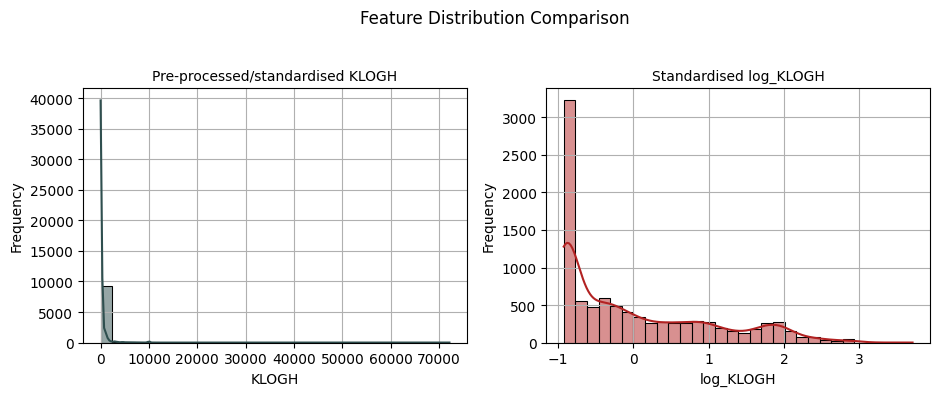

In [20]:
import pandas as pd
train_well_data = pd.concat((pd.read_csv(path) for path in train_well_data_path), ignore_index=True)
DataProcess.compare_distributions(train_well_data, scaled_train_well_data, 'KLOGH','log_KLOGH', title = 'Feature Distribution Comparison')

                             # can plot processed_train_well_data and scaled_train_well_data to compare too.

##### II$\,\,\,\,\,\,$K-Nearest Neighbours for Classification

<p>K-Nearest Neighbours (KNN) is a supervised machine learning algorithm used for classification and regression. It classifies a data point based on the majority class of its closest <em>k</em> neighbours in the feature space.

In this notebook, we apply KNN to classify lithology types from well log data. Given a new data point, KNN will predict its lithology based on similar known samples. This approach is useful when we have well-separated clusters of lithology types.</p>



In [21]:
# KNNClassification >> module to train a KNN classifier on labelled well log data, predict lithology labels for query data points, and evaluate accuracy of trained model
from GeosciencePlusAI.Lib.ClassificationFunctions import KNNClassification
KNNClassifier = KNNClassification()

<p>We start off with determining <em>k</em>, the number of neighbours considered for classification. Using the <code>tune_knn_k()</code> function, we can test different <em>k</em> values (from 1 to k_max) on the standardised training and validation well log data. The best <em>k</em> value is one that maximises accuracy.

First, select the feature columns and the target column.

In [22]:
feature_columns = ['BVW', 'log_KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'log_RT']
target_column = 'LITHOLOGY'

And then, run <code>tune_knn_k()</code>.

Accuracy for k=1: 0.7200
Accuracy for k=2: 0.7200
Accuracy for k=3: 0.7332
Accuracy for k=4: 0.7341
Accuracy for k=5: 0.7379
Accuracy for k=6: 0.7387
Accuracy for k=7: 0.7416
Accuracy for k=8: 0.7434
Accuracy for k=9: 0.7442
Accuracy for k=10: 0.7458
Accuracy for k=11: 0.7475
Accuracy for k=12: 0.7500
Accuracy for k=13: 0.7503
Accuracy for k=14: 0.7504
Accuracy for k=15: 0.7514
Accuracy for k=16: 0.7519
Accuracy for k=17: 0.7522
Accuracy for k=18: 0.7532
Accuracy for k=19: 0.7529
Accuracy for k=20: 0.7526

Best k: 18 with accuracy: 0.7532


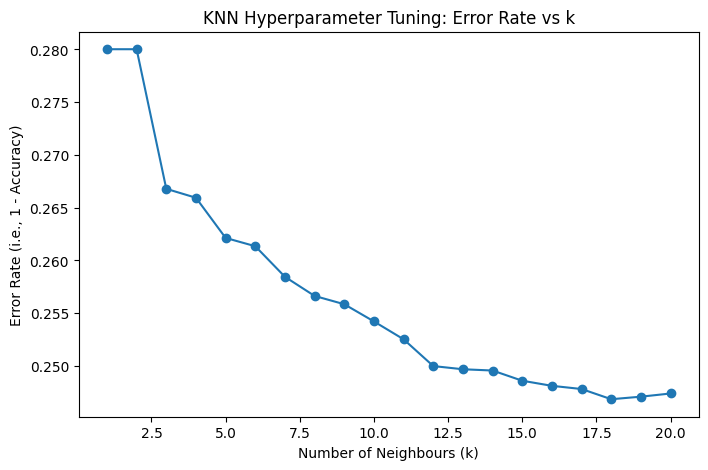

In [23]:
best_k, best_knn_model, best_accuracy = KNNClassifier.tune_knn_k(scaled_train_well_data, scaled_val_well_data, feature_columns, target_column, k_max = 20, weights = 'distance', metric = 'euclidean') # another option: 'uniform'
                                                                 # weights = 'uniform' assigns uniform weights to each neighbour.
                                                                 # for weights = 'distance', closer neighbours have more influence on the prediction, while farther ones have less influence.
                                                                # another option: 'manhattan'

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = [{'n_neighbors': [i for i in range(1, 50)], 'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance']}]

clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')

X_train = scaled_train_well_data[feature_columns]
y_train = scaled_train_well_data[target_column]

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [26]:
clf.best_score_

np.float64(0.9475143349482467)

In [27]:
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

<p>Now, we can train the KNN classifier using <code>train_knn()</code>. It takes as input the scaled training data, the feature and target columns, and the optimal <em>k</em> value.

In [28]:
trained_KNN = KNNClassifier.train_knn(scaled_train_well_data, feature_columns, target_column, k=4)

We can use `test_knn()` function to apply the trained KNN model to the scaled validation data to predict lithology labels.

In [29]:
processed_val_singles_data = DataProcess.process_well_data(val_well_data_path, selected_columns_test, show_stats = False)

scaled_val_singles_well_data = []
for well in processed_val_singles_data:
  scaled_df = DataProcess.scale_dataframe(well, show_stats = False)
  scaled_val_singles_well_data.append(scaled_df)

# Store predictions for the first validation well separately
accuracy_val_KNN_well0, val_KNN_predicted_lithology_well0 = KNNClassifier.test_knn(trained_KNN, scaled_val_singles_well_data[0], feature_columns, target_column)
print(f"Accuracy of KNN when tested on well 0 is {accuracy_val_KNN_well0}")

# Store predictions for the second validation well separately
accuracy_val_KNN_well1, val_KNN_predicted_lithology_well1 = KNNClassifier.test_knn(trained_KNN, scaled_val_singles_well_data[1], feature_columns, target_column)
print(f"Accuracy of KNN when tested on well 1 is {accuracy_val_KNN_well1}")

Accuracy of KNN when tested is 0.7147714393653193
Accuracy of KNN when tested on well 0 is 0.7147714393653193
Accuracy of KNN when tested is 0.7377320477766585
Accuracy of KNN when tested on well 1 is 0.7377320477766585


<p>We use <code>plot_lithology_comparison()</code> To visually compare the predictions of the trained KNN with the actual lithology.</p>

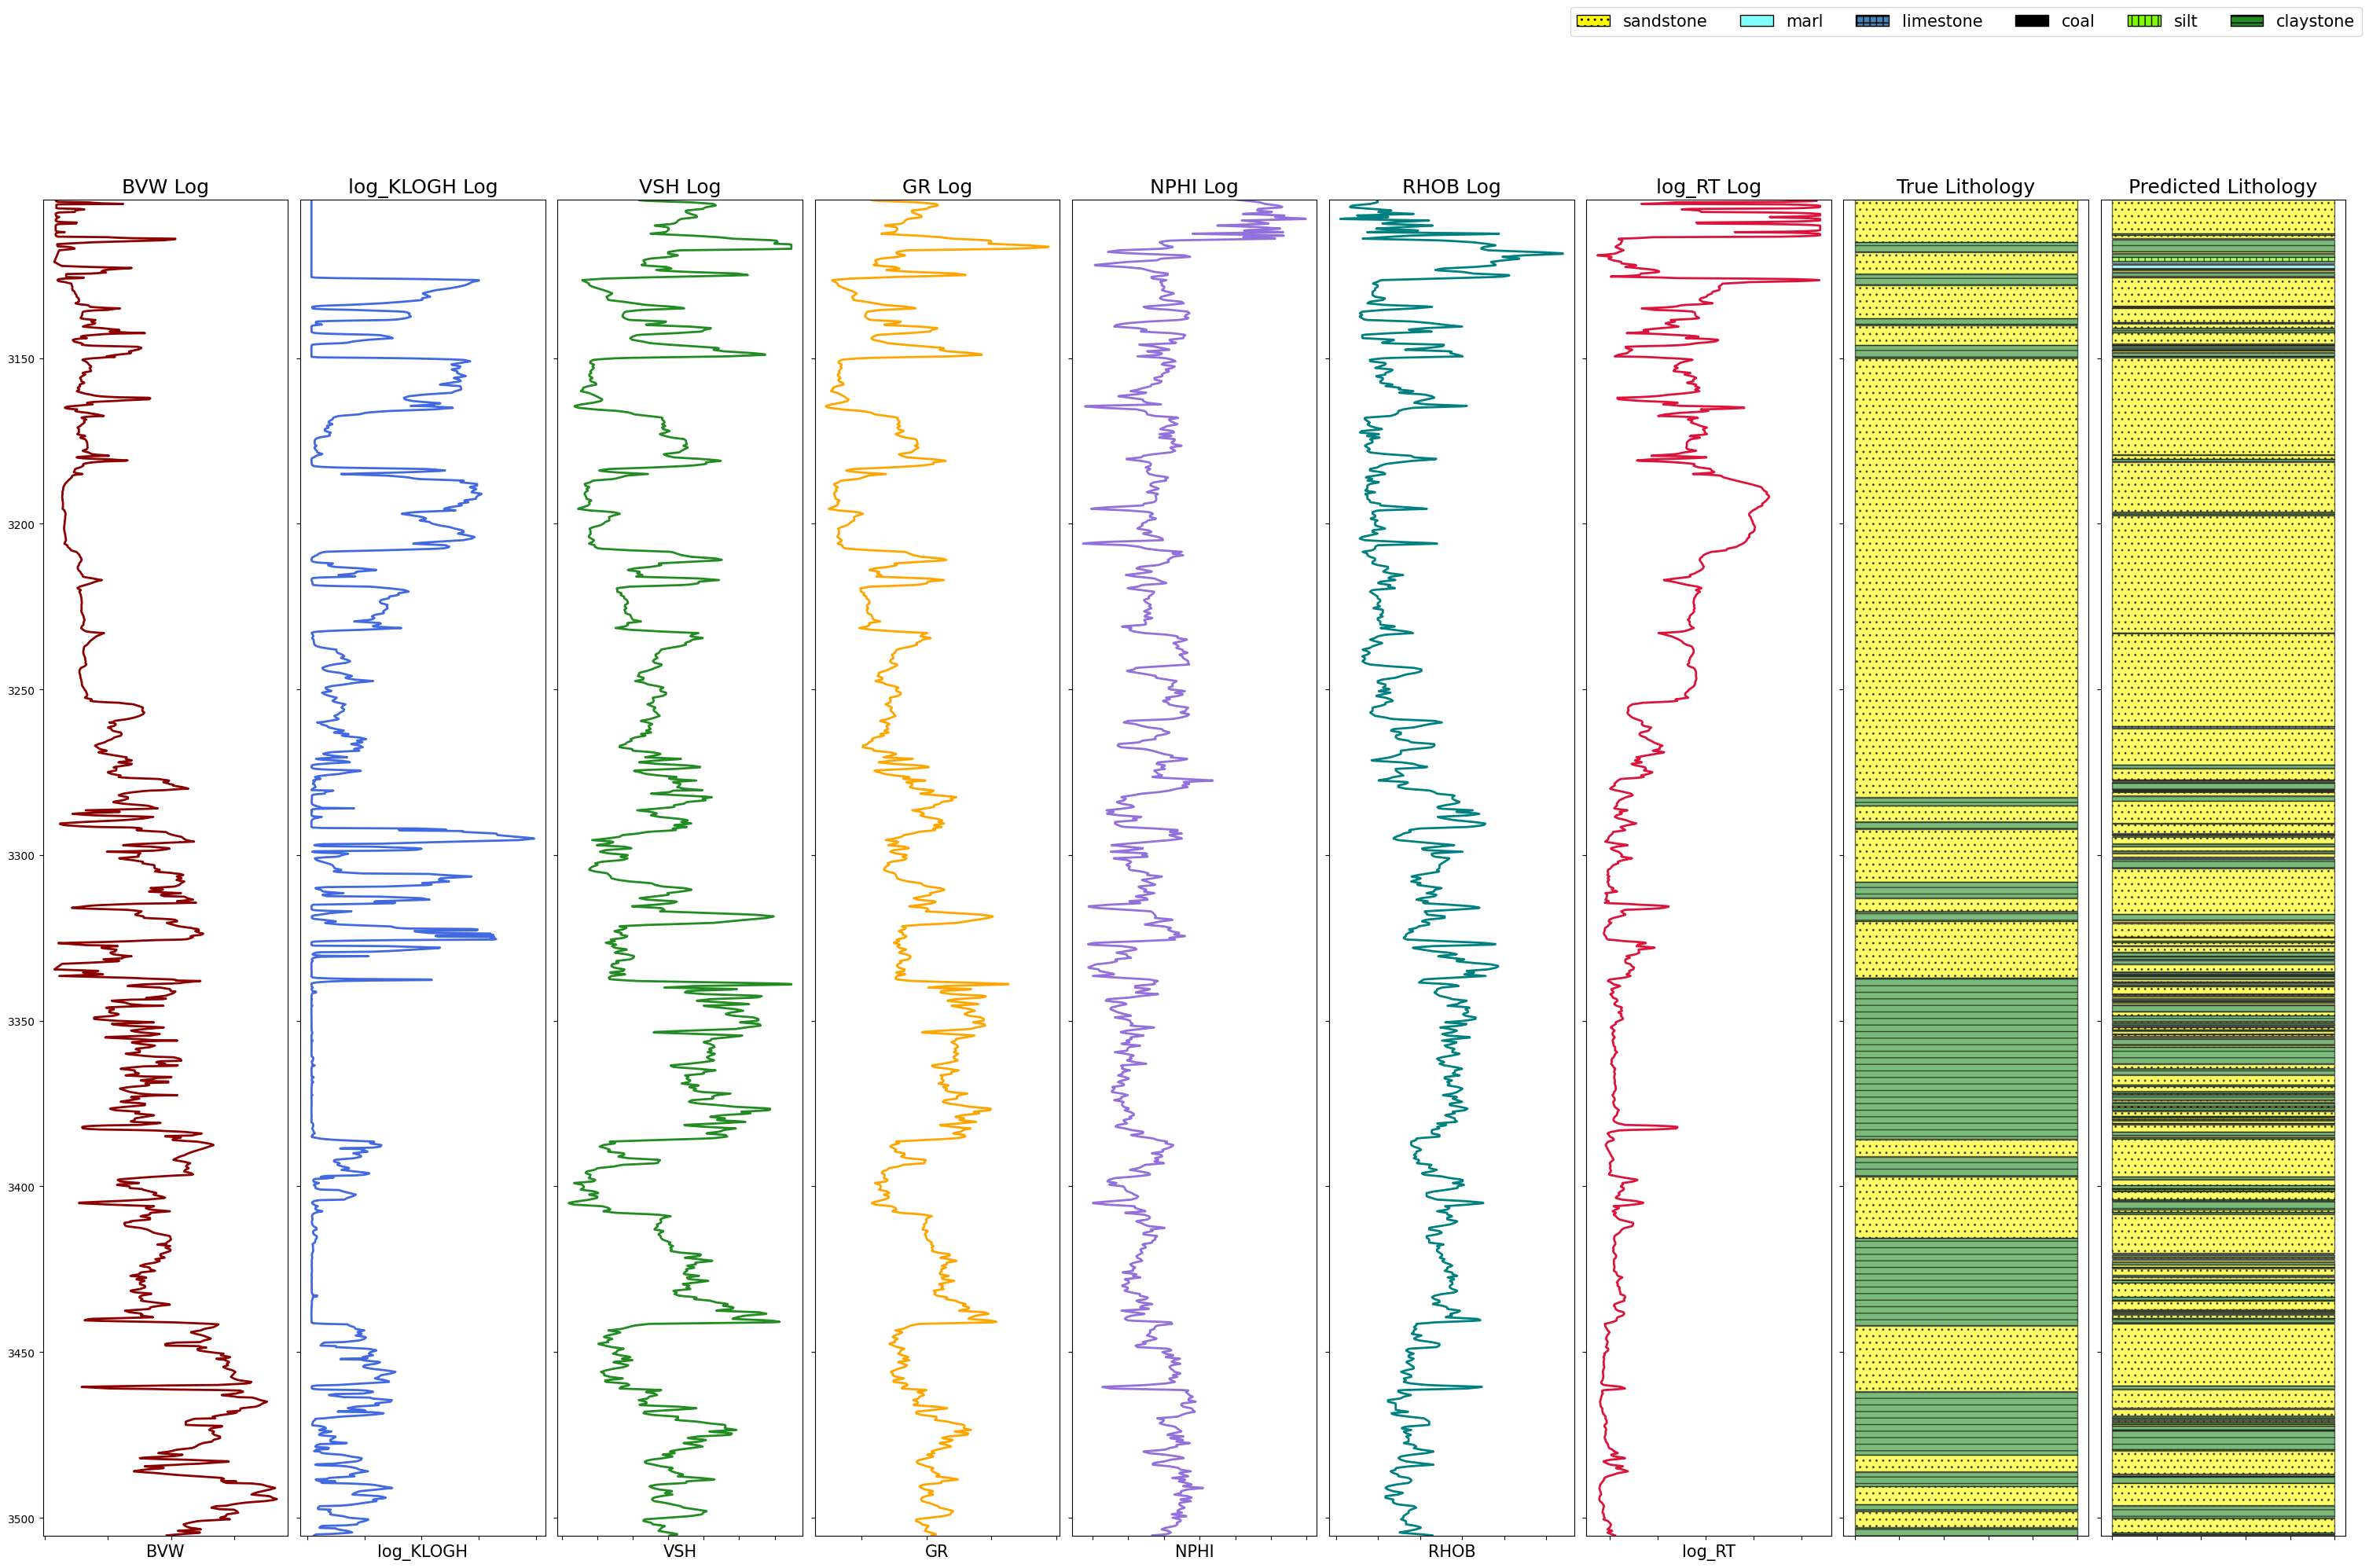

In [30]:

KNNClassifier.plot_lithology_comparison(scaled_val_singles_well_data[0], val_KNN_predicted_lithology_well0, use_hatch = True, log_columns = feature_columns)

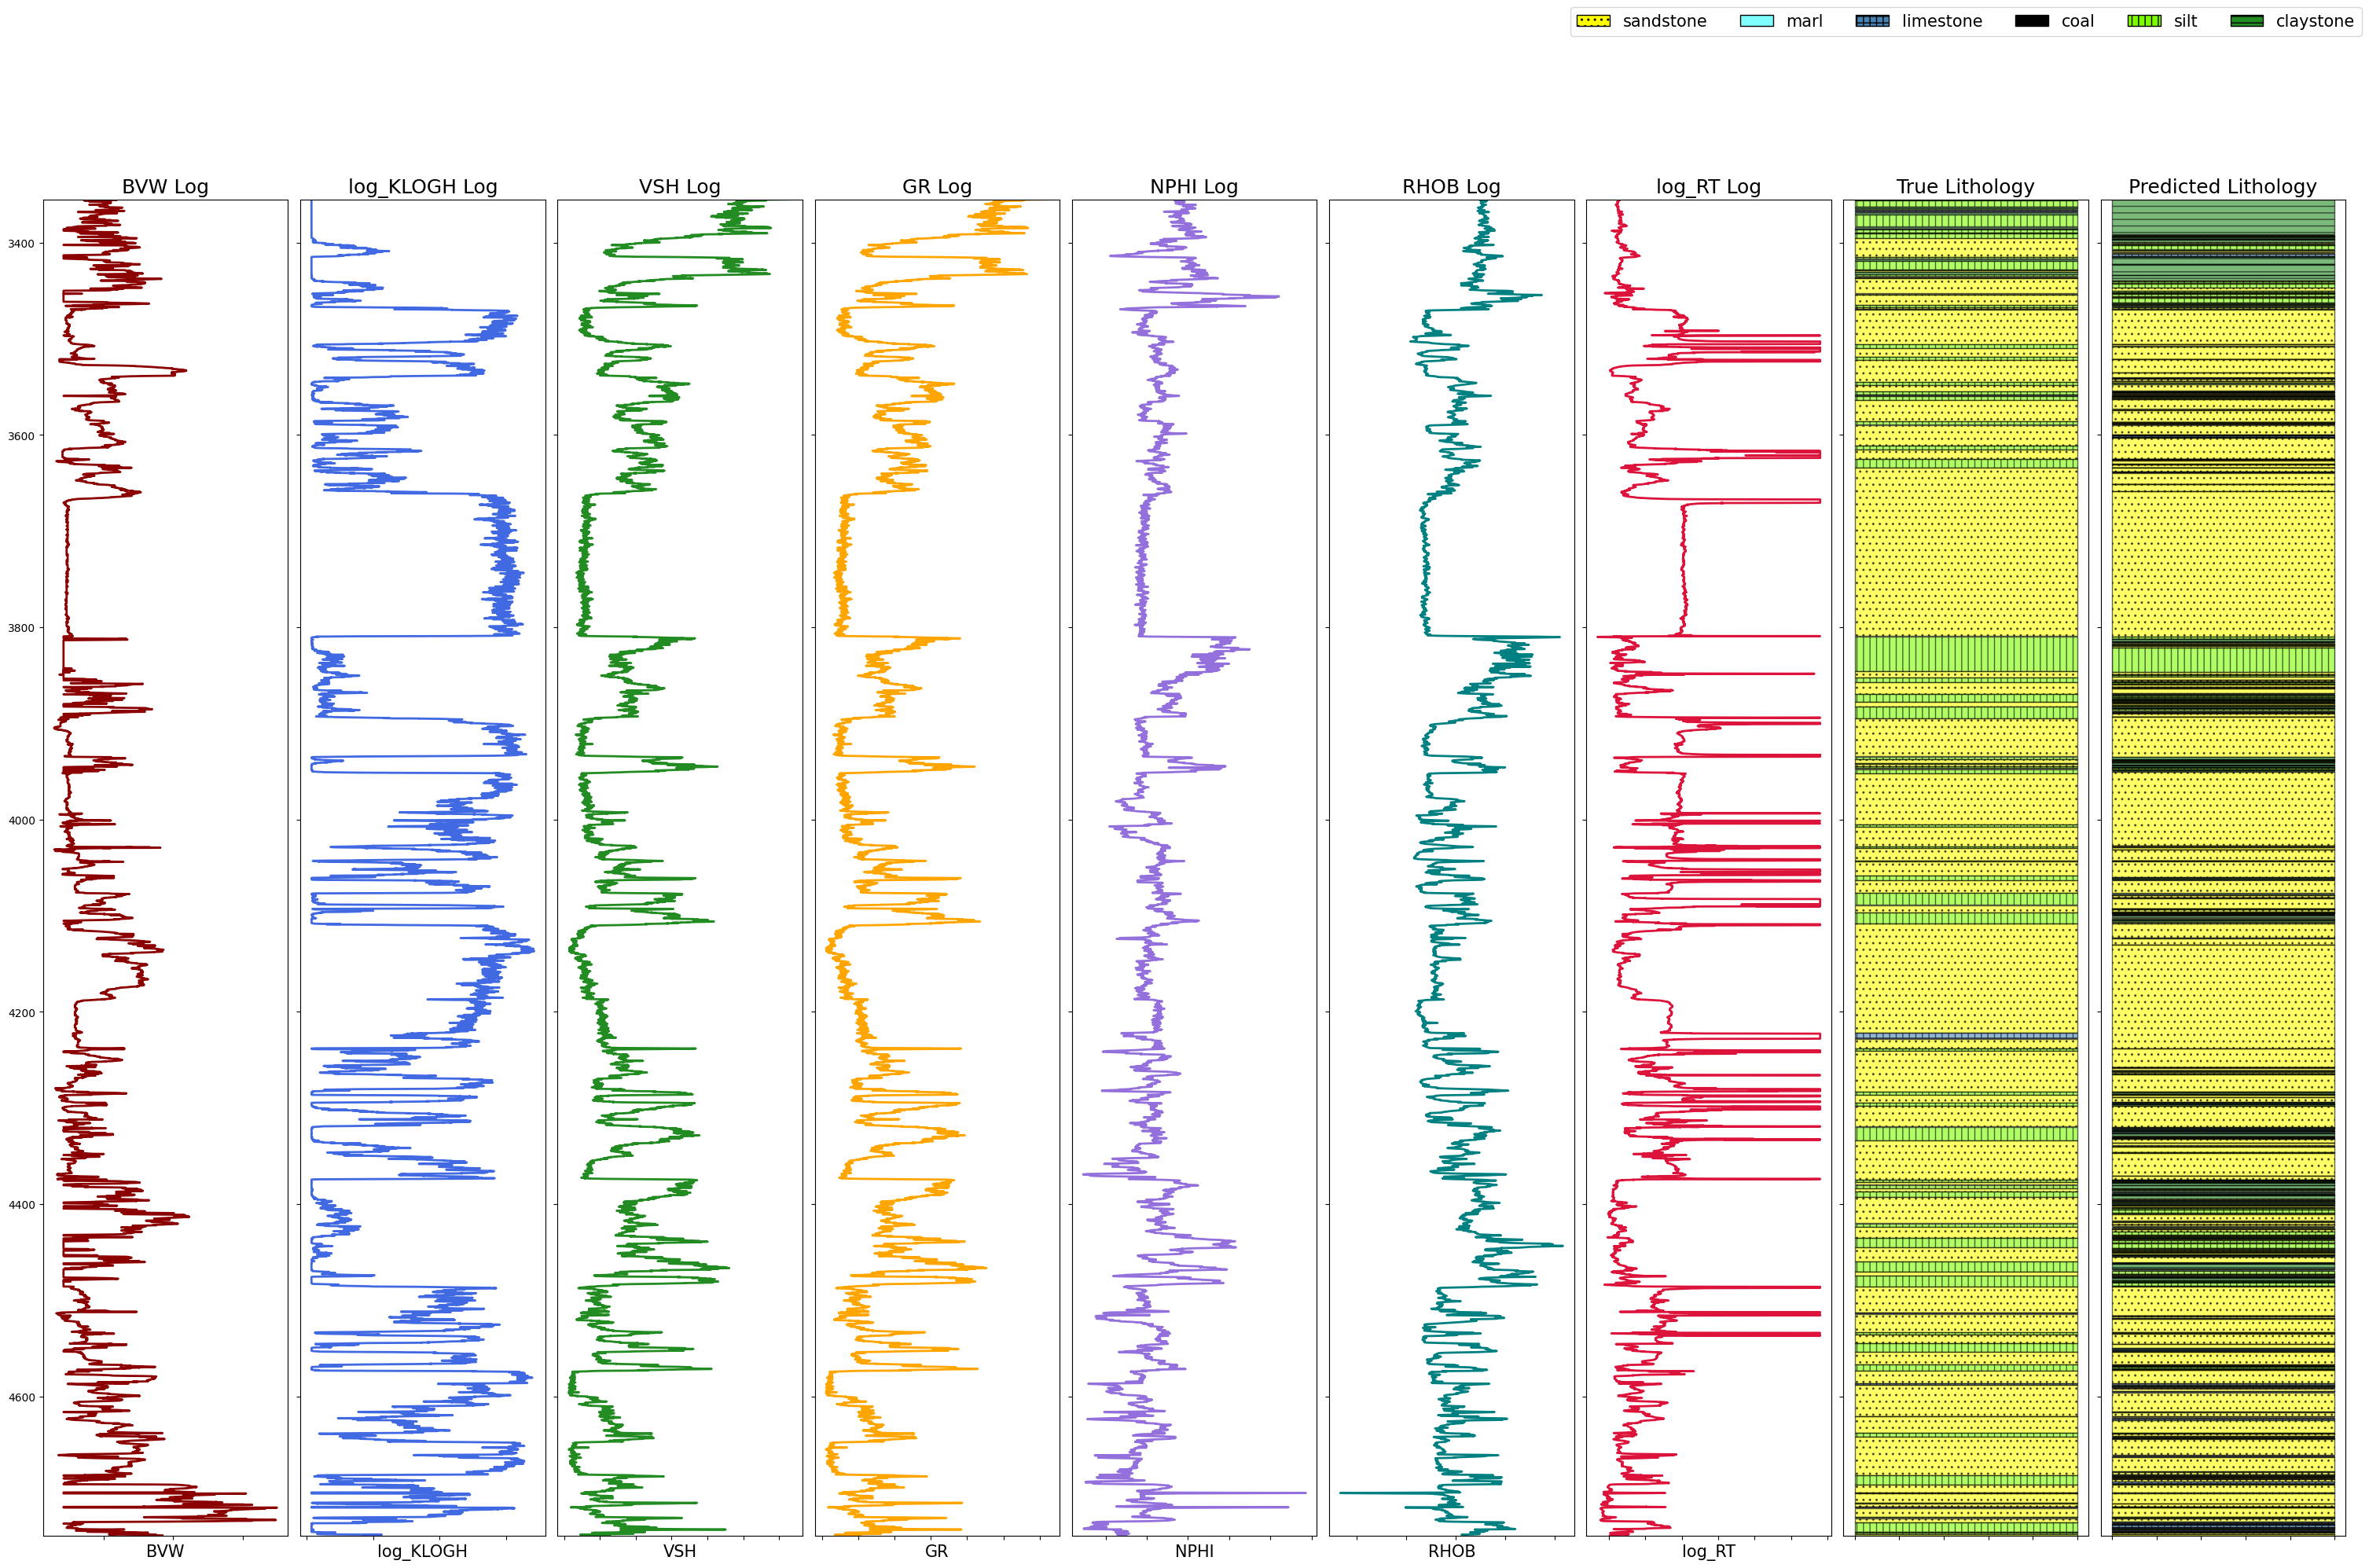

In [31]:
KNNClassifier.plot_lithology_comparison(scaled_val_singles_well_data[1], val_KNN_predicted_lithology_well1, use_hatch = True, log_columns = feature_columns)

Using `test_knn()`, we can also apply the trained KNN model to the scaled test data to predict lithology labels.

In [32]:
accuracy_test_KNN0, test_KNN_predicted_lithology0 = KNNClassifier.test_knn(trained_KNN, scaled_test_well_data[0], feature_columns, target_column)

Accuracy of KNN when tested is 0.7650455927051671


In [33]:
accuracy_test_KNN1, test_KNN_predicted_lithology1 = KNNClassifier.test_knn(trained_KNN, scaled_test_well_data[1], feature_columns, target_column)

Accuracy of KNN when tested is 0.7659484579636671


In [34]:
from sklearn.metrics import classification_report

print(classification_report(scaled_test_well_data[0][target_column], test_KNN_predicted_lithology0))

              precision    recall  f1-score   support

   Claystone       0.90      0.66      0.76      1429
        Coal       0.00      0.00      0.00        29
   Limestone       0.31      0.39      0.35        76
        Marl       0.64      0.60      0.62       309
   Sandstone       0.77      0.94      0.85      1447
        Silt       0.00      0.00      0.00         0

    accuracy                           0.77      3290
   macro avg       0.44      0.43      0.43      3290
weighted avg       0.80      0.77      0.77      3290



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
from sklearn.metrics import classification_report

print(classification_report(scaled_test_well_data[1][target_column], test_KNN_predicted_lithology1))

              precision    recall  f1-score   support

   Claystone       0.86      0.62      0.72       761
        Coal       1.00      0.12      0.22        49
   Limestone       0.38      0.08      0.13       171
        Marl       0.00      0.00      0.00         0
   Sandstone       0.82      0.96      0.89      1360
        Silt       0.08      0.54      0.14        26

    accuracy                           0.77      2367
   macro avg       0.52      0.39      0.35      2367
weighted avg       0.80      0.77      0.76      2367



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<p>And then, we use <code>plot_lithology_comparison()</code> to create a depth profile plot with side-by-side comparisons of the true lithology from the test dataset and the predicted lithology from the trained KNN.</p>

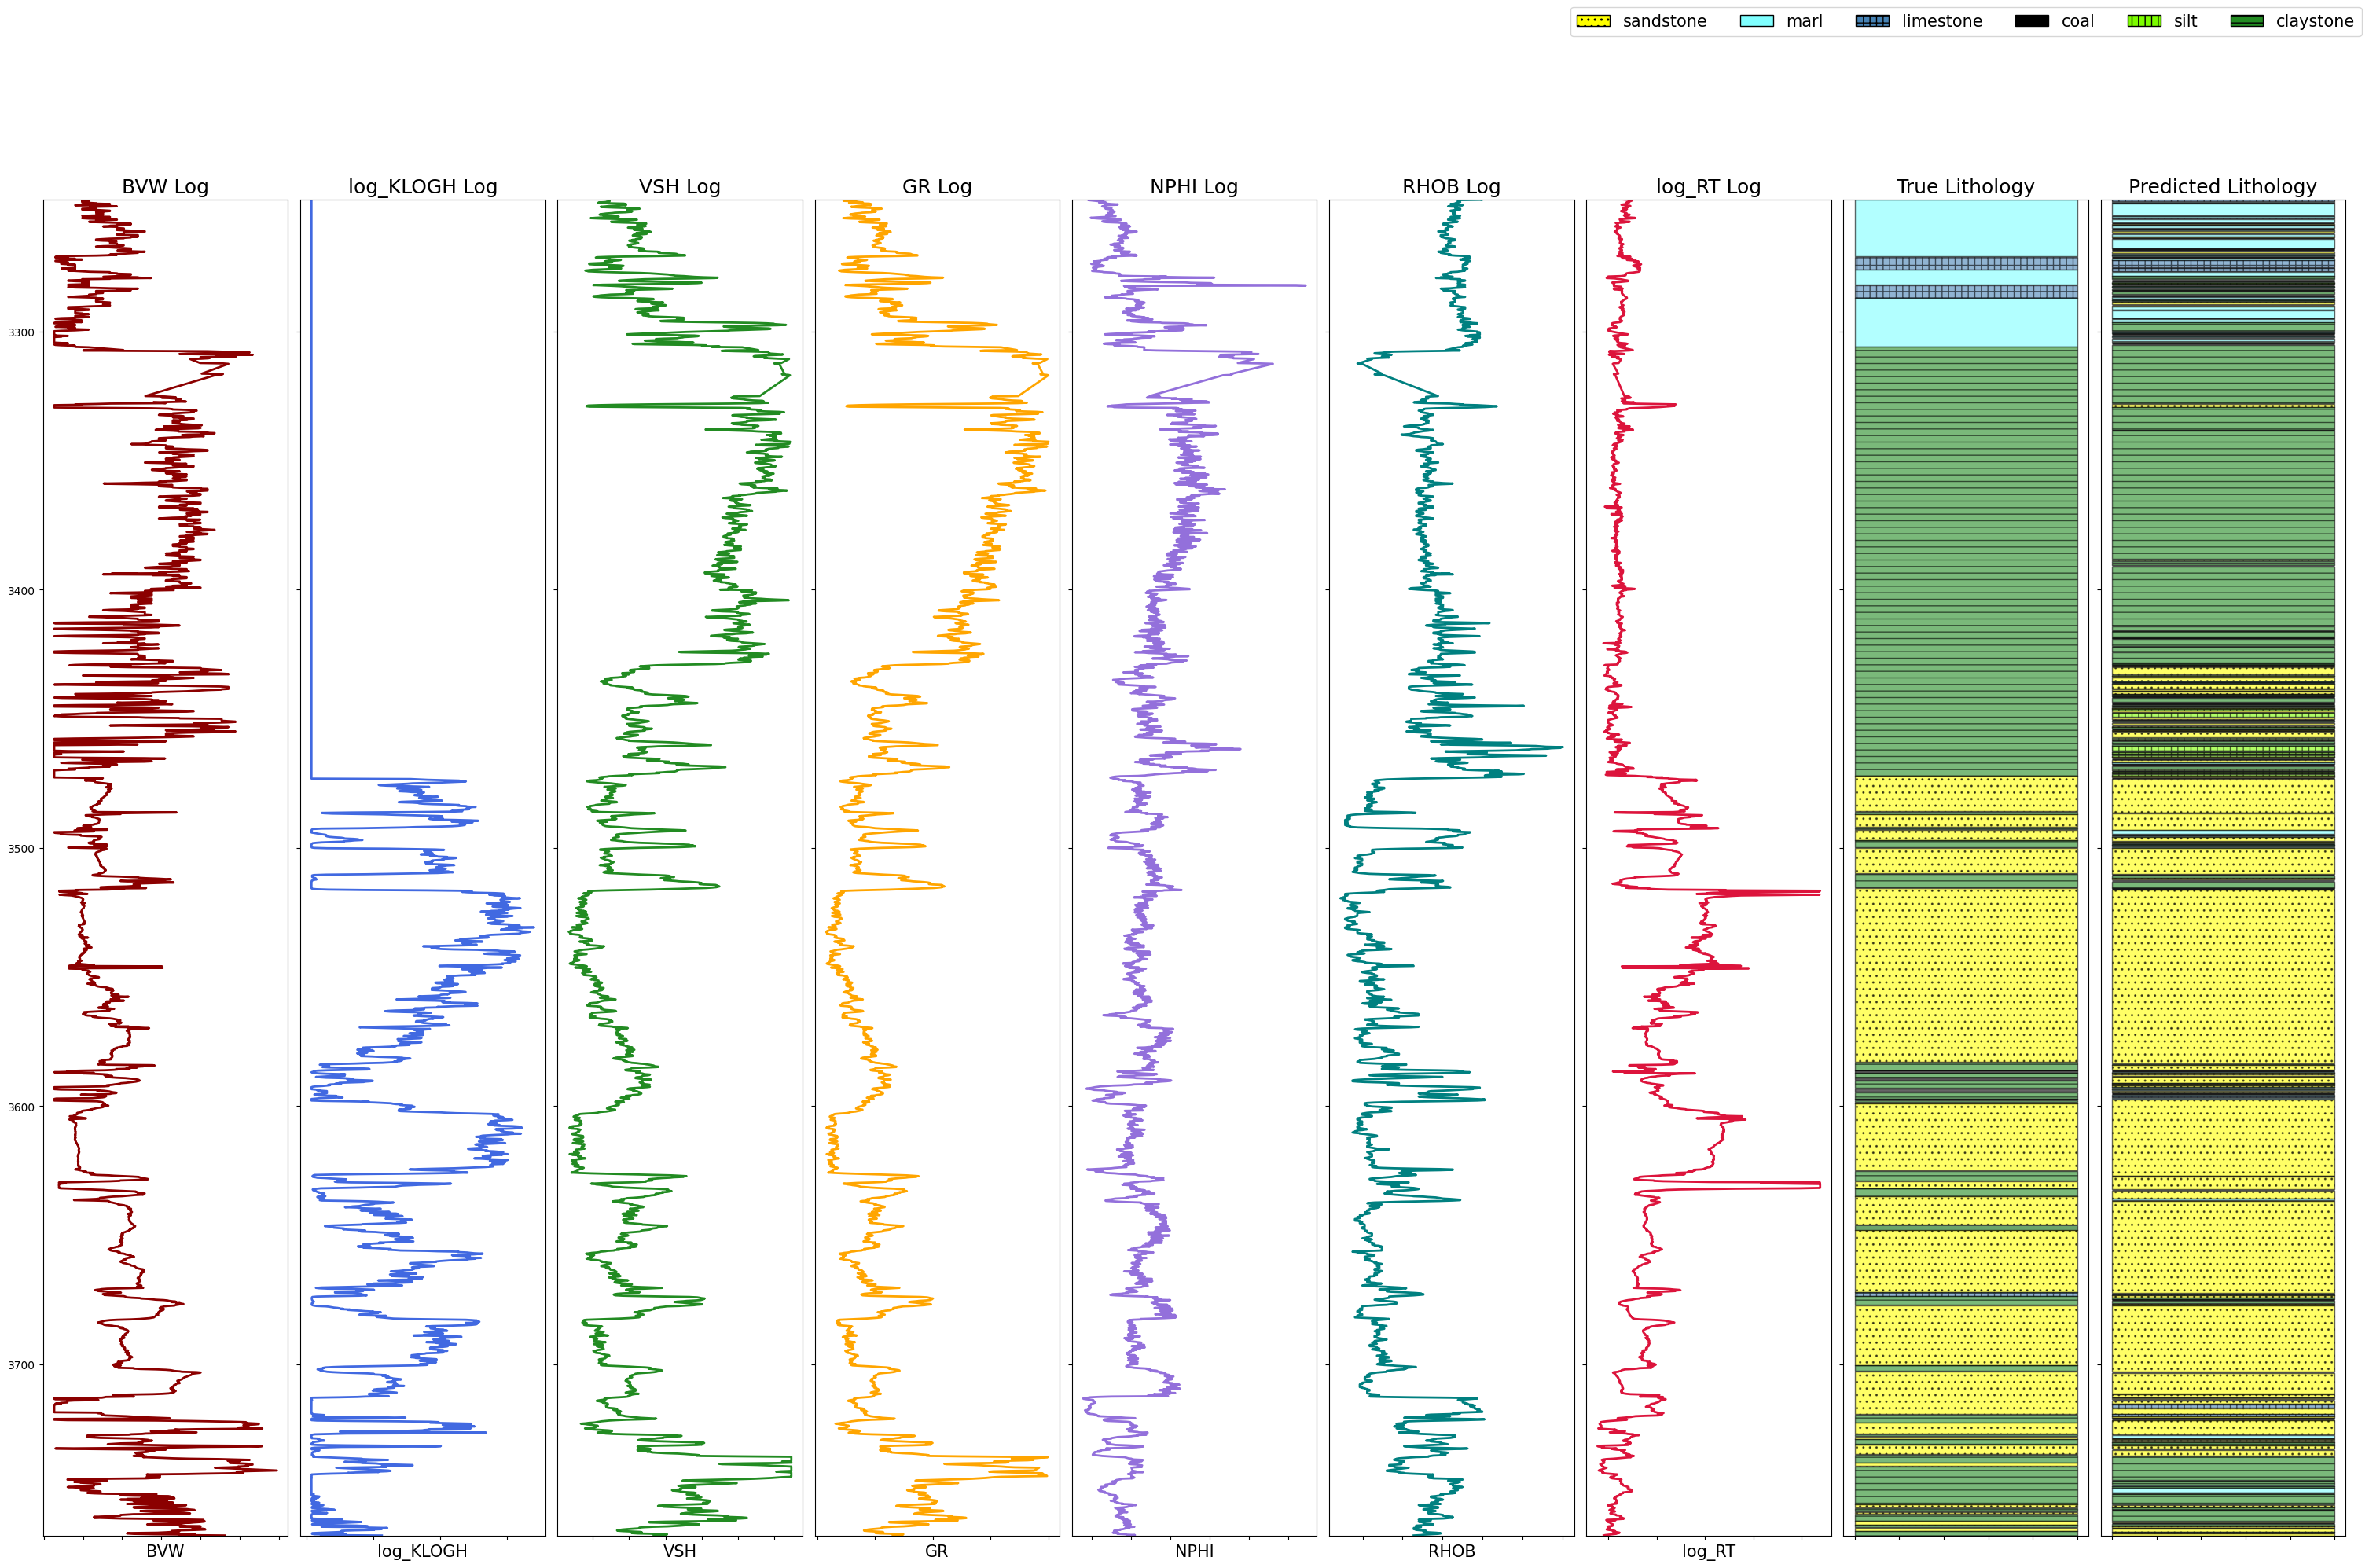

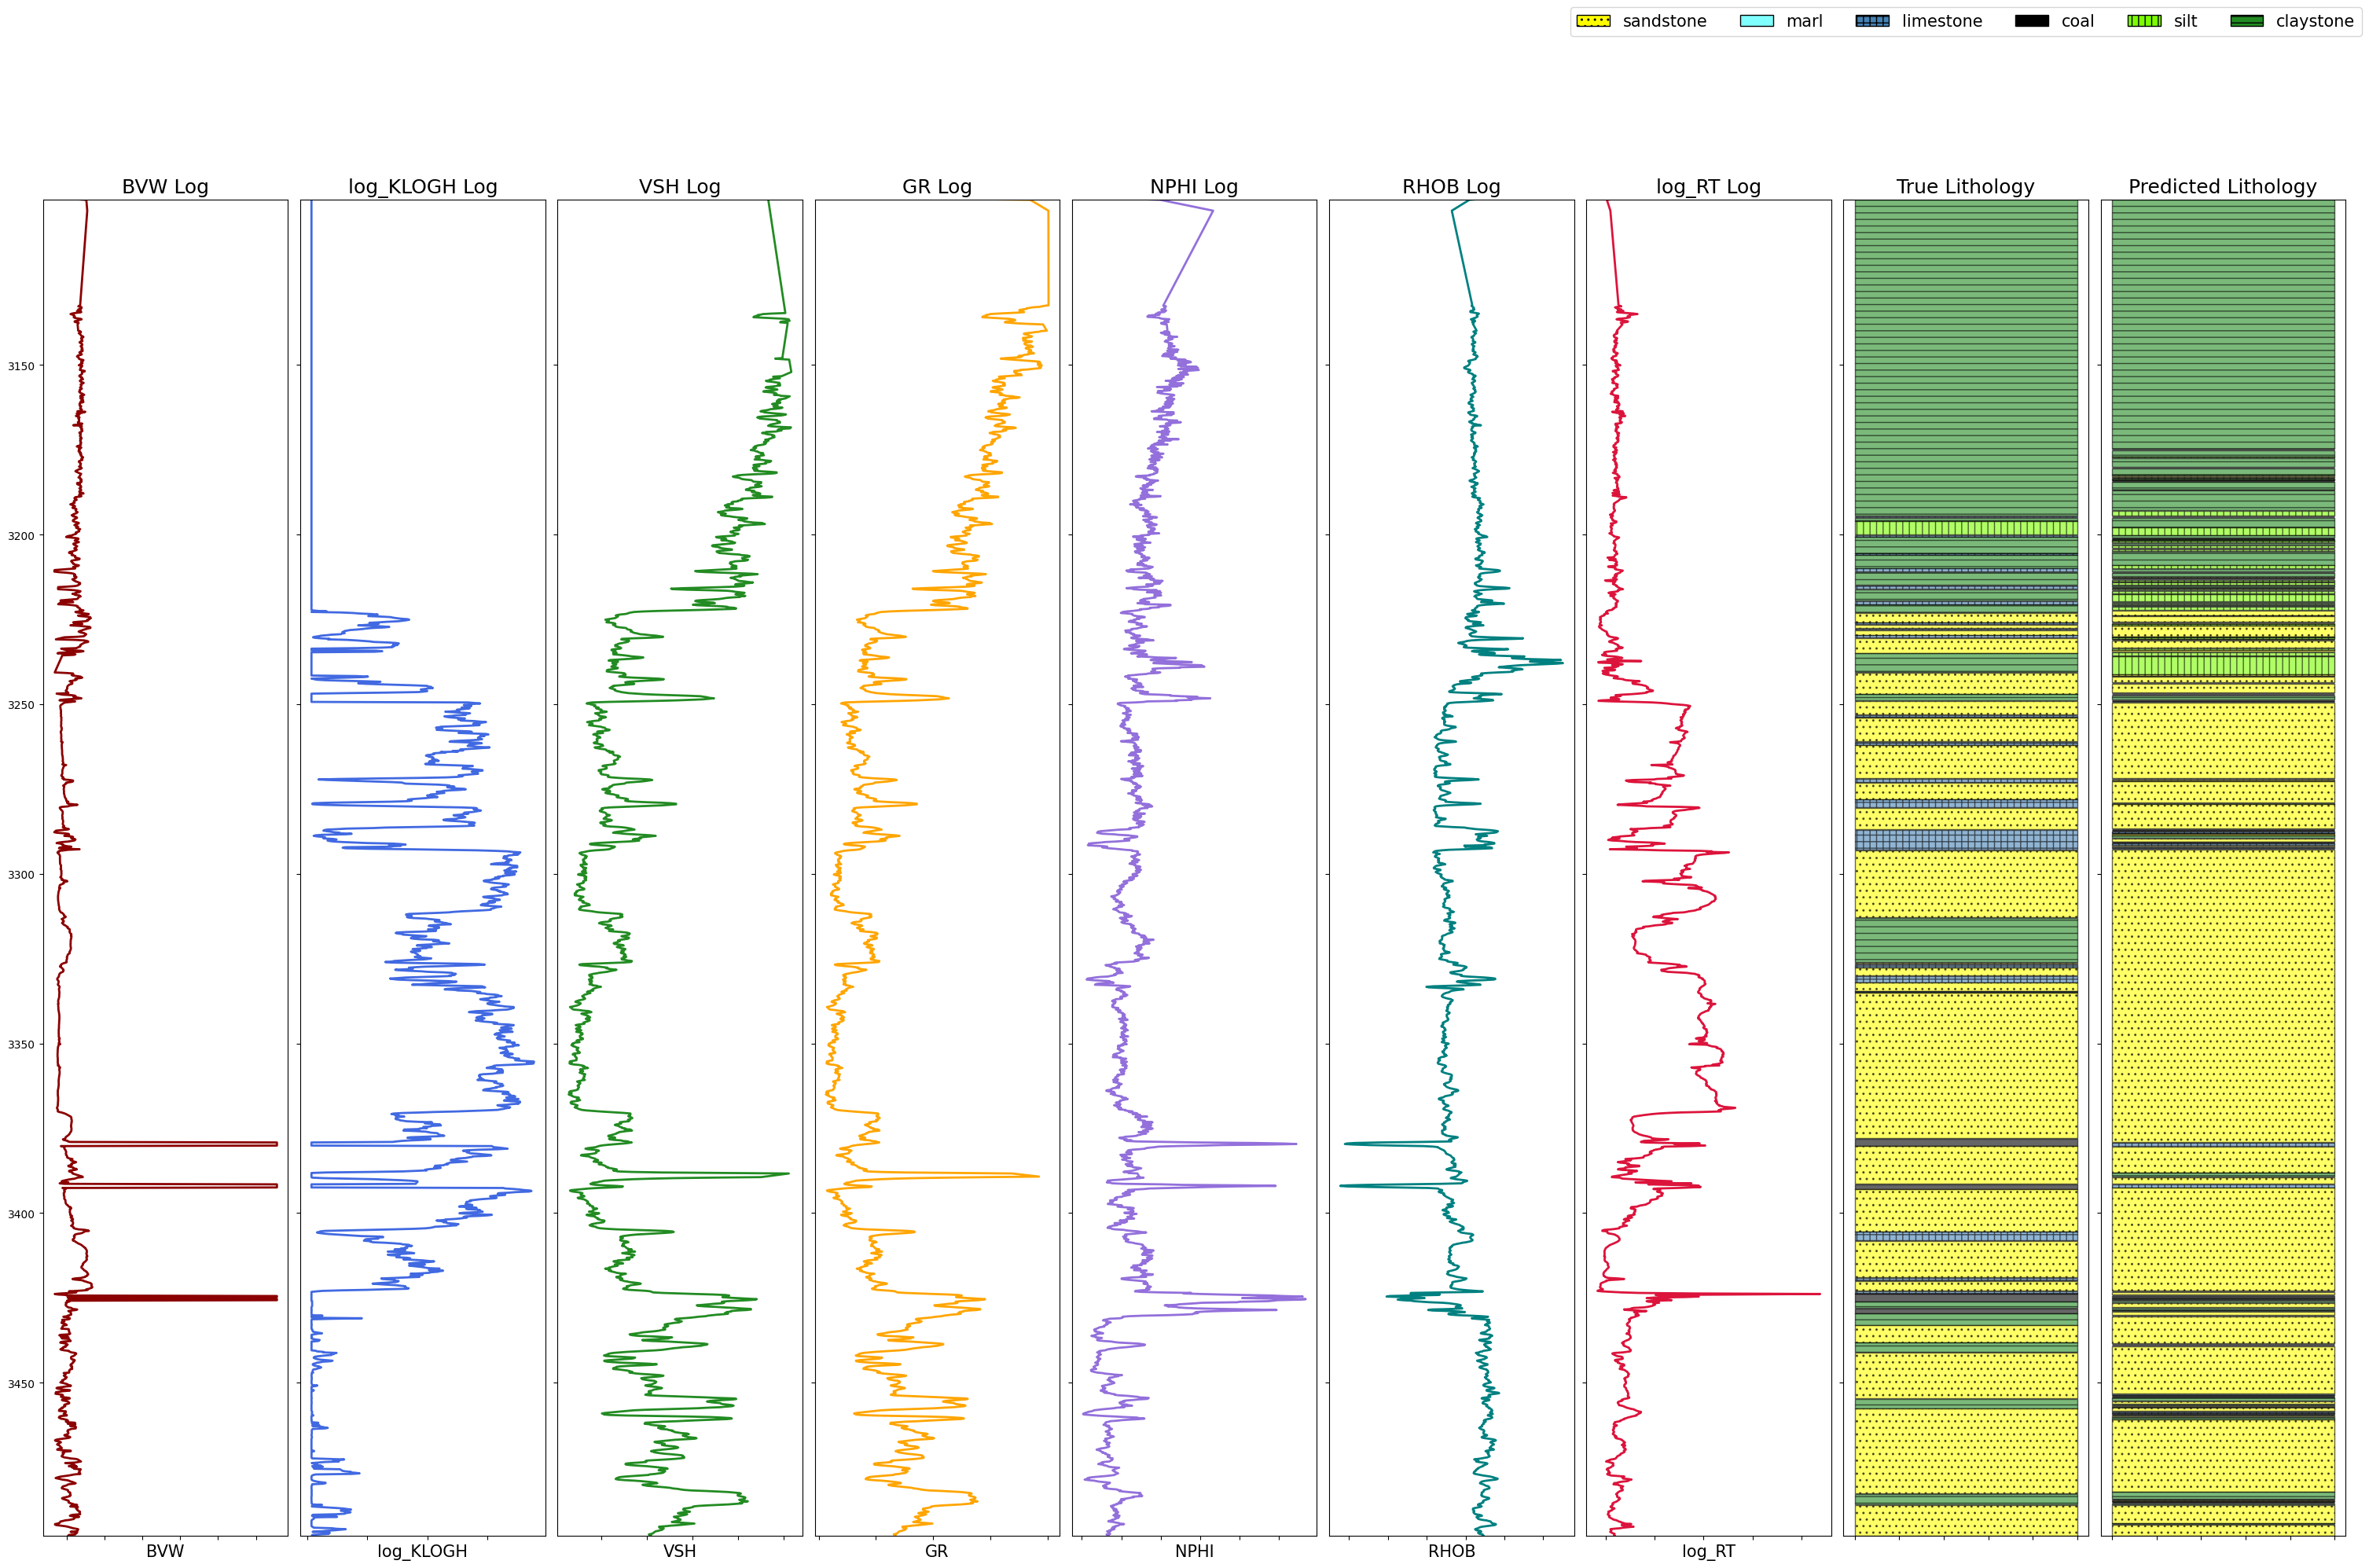

In [36]:
test_predicted_wells = list([test_KNN_predicted_lithology0, test_KNN_predicted_lithology1])

for wells, y_pred in zip (scaled_test_well_data, test_predicted_wells):
  KNNClassifier.plot_lithology_comparison(wells, y_pred, use_hatch= True, log_columns =feature_columns)

<p>We can also use the <code>plot_confusion_matrix()</code> function to evaluate the classification performance of the KNN model. This function generates a confusion matrix, which provides insights into how well the model distinguishes between different lithology classes. </p>

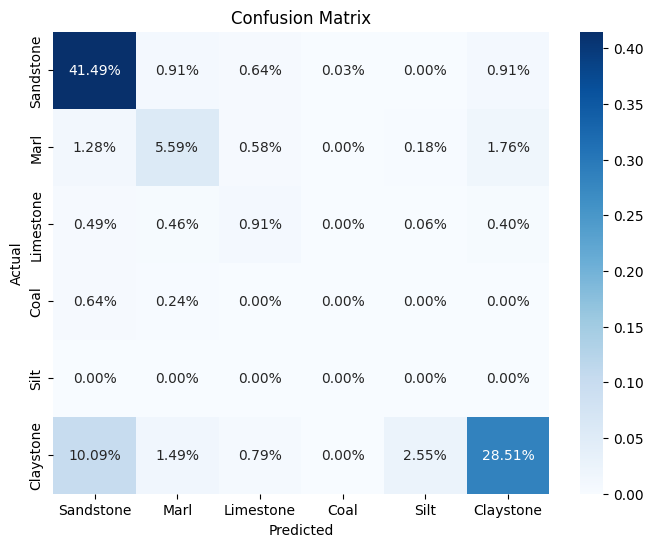

In [37]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[0]['LITHOLOGY'].values, test_KNN_predicted_lithology0, percentage=True) # you can also set percentage=True >> instead of counts, the values of the matrix are displayed as %

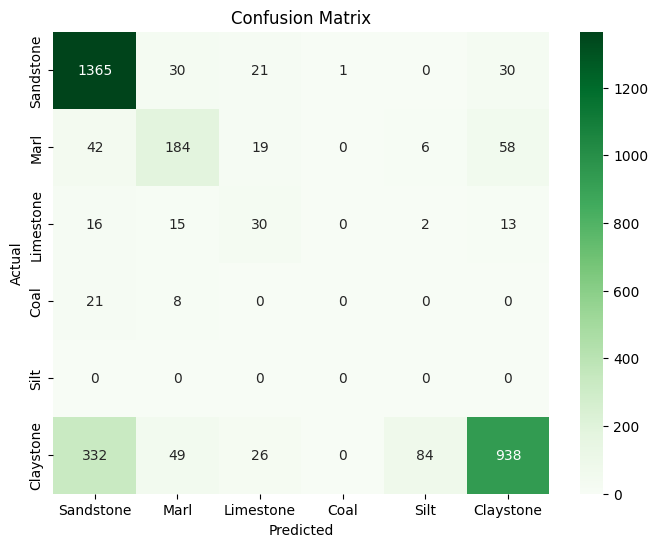

In [38]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[0]['LITHOLOGY'].values, test_KNN_predicted_lithology0, percentage=False)

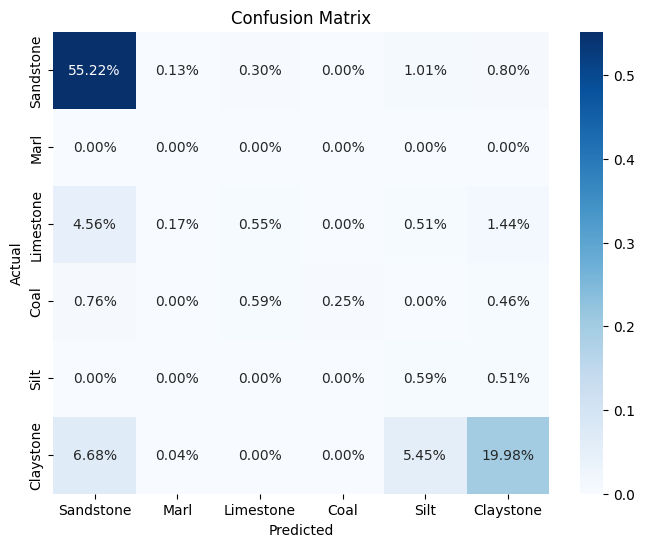

In [39]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[1]['LITHOLOGY'].values, test_KNN_predicted_lithology1, percentage=True)

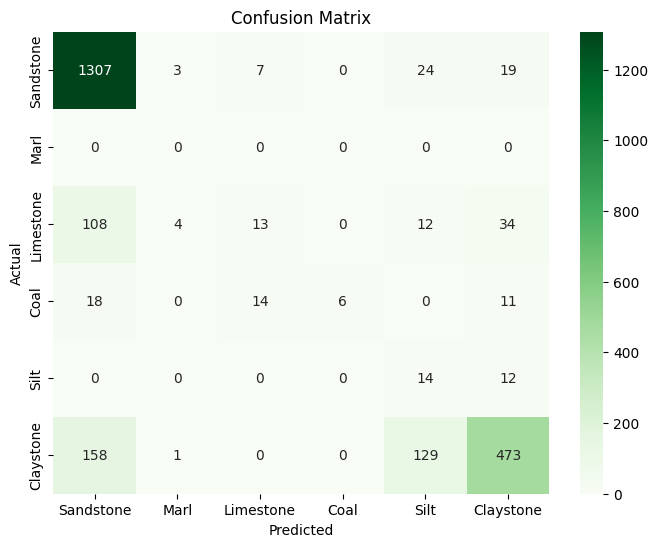

In [40]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[1]['LITHOLOGY'].values, test_KNN_predicted_lithology1, percentage=False)

##### III$\,\,\,\,\,\,$Random Forest for Classification



Another commonly used classifier is Random Forest, an ensemble learning method that builds multiple decision trees and combines their outputs to improve classification accuracy.

In [42]:
from GeosciencePlusAI.Lib.ClassificationFunctions import RFClassification
RFClassifier = RFClassification()

<p>We define a dictionary of hyperparameters (`rf_params`) that control how the Random Forest is built and how complex the trees can become.</p>

In [43]:
rf_params={'n_estimators':200,         # Number of trees in the forest
    'max_depth': 30,             # Maximum depth of each tree (limits tree growth) - how many levels of split can we see?
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,       # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',      # Number of features to consider when looking for the best split ('sqrt' = sqrt of total features)
    'bootstrap': True,           # Whether bootstrap samples are used when building trees (True enables sampling with replacement)
    'random_state': 42           # Seed used by the random number generator for reproducibility
}

Then we call a custom training function, `RFClassifier.train_random_forest()`, which:

Trains the Random Forest on the scaled training data

*   Trains the Random Forest on the scaled training data
*   Evaluates it on the validation data
*   Returns the trained model, the parameters used, the validation accuracy, and the predicted values

In [44]:
trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data, scaled_val_well_data, feature_columns, target_column, rf_params, print_classification_report = True, print_classification_matrix = True)


Validation Accuracy: 0.7597

Classification Report:
               precision    recall  f1-score   support

   Claystone       0.29      0.60      0.39      1033
        Coal       0.00      0.00      0.00        36
   Limestone       0.06      0.13      0.08       119
        Marl       0.00      0.00      0.00         0
   Sandstone       0.86      0.92      0.89     12325
        Silt       0.57      0.18      0.27      3032

    accuracy                           0.76     16545
   macro avg       0.30      0.30      0.27     16545
weighted avg       0.77      0.76      0.74     16545


Confusion Matrix:
 [[  617     0     0     1   403    12]
 [    6     0    15     0    12     3]
 [   20     0    15     0    84     0]
 [    0     0     0     0     0     0]
 [  368     2   156     7 11391   401]
 [ 1125     0    69     0  1291   547]]


We can also run this in a loop, to test different values of the same hyperparameter. In the example below, we take a closer look at `n_estimators`.

n_estimators=  10
Validation Accuracy: 0.7510

Classification Report:
               precision    recall  f1-score   support

   Claystone       0.29      0.60      0.39      1033
        Coal       0.00      0.00      0.00        36
   Limestone       0.06      0.22      0.10       119
        Marl       0.00      0.00      0.00         0
   Sandstone       0.87      0.91      0.89     12325
        Silt       0.56      0.20      0.29      3032

    accuracy                           0.75     16545
   macro avg       0.30      0.32      0.28     16545
weighted avg       0.77      0.75      0.74     16545


Confusion Matrix:
 [[  616     0     0     0   397    20]
 [    6     0    14     0    14     2]
 [   20     0    26     0    73     0]
 [    0     0     0     0     0     0]
 [  346    37   288    12 11183   459]
 [ 1113     0    95    12  1212   600]]
n_estimators=  50
Validation Accuracy: 0.7631

Classification Report:
               precision    recall  f1-score   support

   Cl

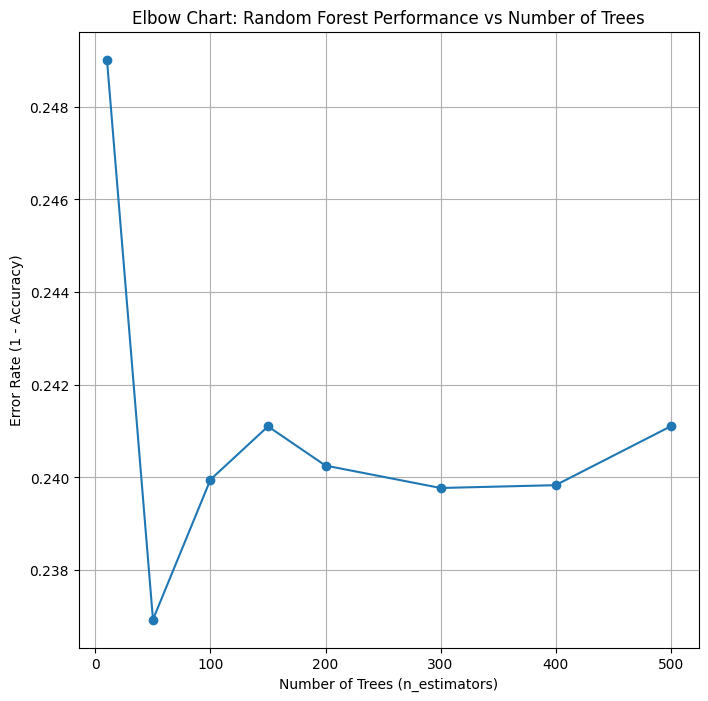

In [45]:
import matplotlib.pyplot as plt

n_estimators_range = [10, 50, 100, 150, 200, 300, 400, 500]
rf_accuracies = []

for n in n_estimators_range:
  print('n_estimators= ',n)

  rf_params = {'n_estimators':n, 'max_depth': 30, 'min_samples_split':4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap' : True,'random_state':42}

  trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data, scaled_val_well_data, feature_columns, target_column, rf_params, print_classification_matrix = True, print_classification_report = True)

  rf_accuracies.append(trained_RF_accuracy)

error_rates = [1 - accuracy for accuracy in rf_accuracies]

#Plot the elbow chart

plt.figure(figsize=(8, 8))
plt.plot(n_estimators_range, error_rates, marker='o')
plt.title('Elbow Chart: Random Forest Performance vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.grid(True)
plt.show()


In [50]:
rf_params = {
    'n_estimators': 300,         # Number of trees in the forest
    'max_depth': 30,             # Maximum depth of each tree (limits tree growth) - how many levels of split can we see?
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,       # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',      # Number of features to consider when looking for the best split ('sqrt' = sqrt of total features)
    'bootstrap': True,           # Whether bootstrap samples are used when building trees (True enables sampling with replacement)
    'random_state': 42           # Seed used by the random number generator for reproducibility
}

trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data,
                                                                                                         scaled_val_well_data,
                                                                                                         feature_columns,
                                                                                                         target_column,
                                                                                                         rf_params,
                                                                                                         print_classification_report=False,
                                                                                                         print_classification_matrix=False)

Validation Accuracy: 0.7602


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = [{'max_depth':[10,15,20,25,30], 'n_estimators': n_estimators_range}]

randm_clf = RandomForestClassifier()

clf = GridSearchCV(randm_clf, tuned_parameters, cv = 5, scoring = 'accuracy')

train_X = scaled_train_well_data[feature_columns]
train_y = scaled_train_well_data[target_column] # Corrected: use training data for y_train

clf.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 15, 20, 25, 30],
                          'n_estimators': [10, 50, 100, 150, 200, 300, 400,
                                           500]}],
             scoring='accuracy')

In [53]:
clf.best_score_

np.float64(0.9536325185046961)

In [54]:
clf.best_params_

{'max_depth': 20, 'n_estimators': 500}

In [56]:
rf_params = {
    'n_estimators': 300,         # Number of trees in the forest
    'max_depth': 30,             # Maximum depth of each tree (limits tree growth) - how many levels of split can we see?
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,       # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',      # Number of features to consider when looking for the best split ('sqrt' = sqrt of total features)
    'bootstrap': True,           # Whether bootstrap samples are used when building trees (True enables sampling with replacement)
    'random_state': 42           # Seed used by the random number generator for reproducibility
}

trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data,
                                                                                                         scaled_val_well_data,
                                                                                                         feature_columns,
                                                                                                         target_column,
                                                                                                         rf_params,
                                                                                                         print_classification_report=False,
                                                                                                         print_classification_matrix=False)

Validation Accuracy: 0.7602


<p>After training, we evaluate the model on the test dataset using the <code>test_random_forest</code> function. The trained Random Forest classifier predicts lithology classes, which we can later compare to actual lithology labels. This step helps us understand how well the model generalises to new data.</p>

In [58]:
accuracy_test_RF, test_RF_predicted_lithology0 = RFClassifier.test_random_forest(trained_RF, scaled_test_well_data[0], feature_columns, target_column)

Test Accuracy: 0.7790
Confusion Matrix:
 [[ 948    0    8   20  453]
 [   4    0    0    0   25]
 [   4    0   31   21   20]
 [  96    0   15  176   22]
 [  21    0   15    3 1408]]


In [59]:
accuracy_test_RF, test_RF_predicted_lithology1 = RFClassifier.test_random_forest(trained_RF, scaled_test_well_data[1], feature_columns, target_column)

Test Accuracy: 0.8019
Confusion Matrix:
 [[ 571    0    0    3  177   10]
 [  10   13   15    0   11    0]
 [  40    0   13    0  115    3]
 [   0    0    0    0    0    0]
 [  23    0   16   17 1296    8]
 [  21    0    0    0    0    5]]


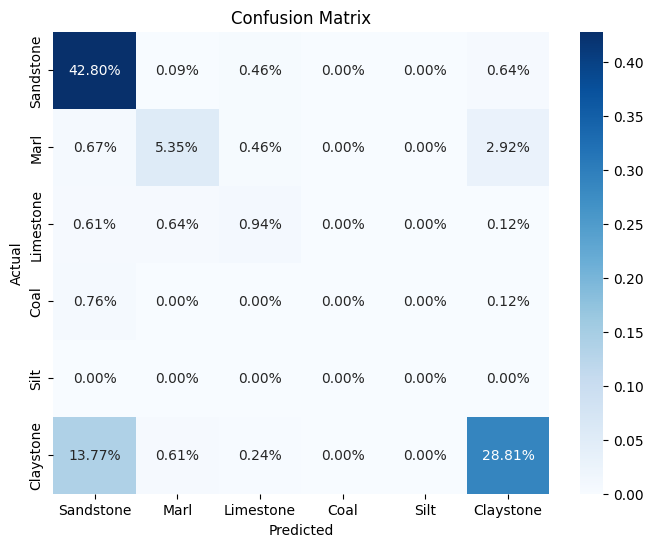

In [60]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[0]['LITHOLOGY'].values, test_RF_predicted_lithology0, percentage=True)

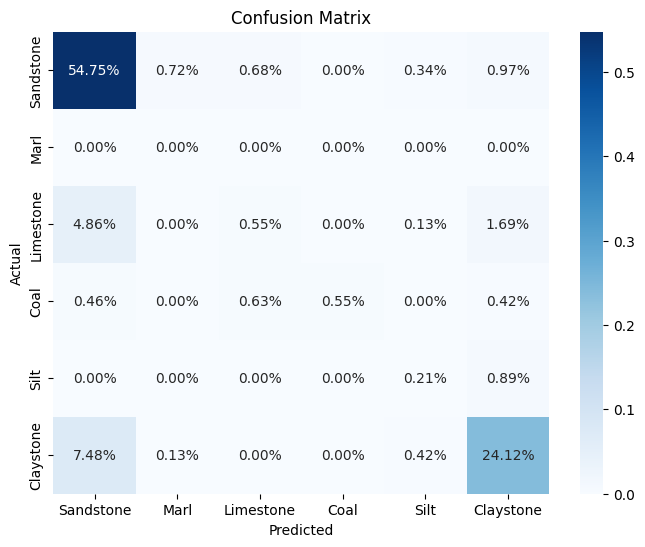

In [61]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[1]['LITHOLOGY'].values, test_RF_predicted_lithology1, percentage = True)

<p>Similar to the earlier section, we can also use the <code>plot_lithology_comparison</code> function to visually compare the predicted lithology labels from the trained Random Forest model with the actual lithology labels in the test dataset.</p>

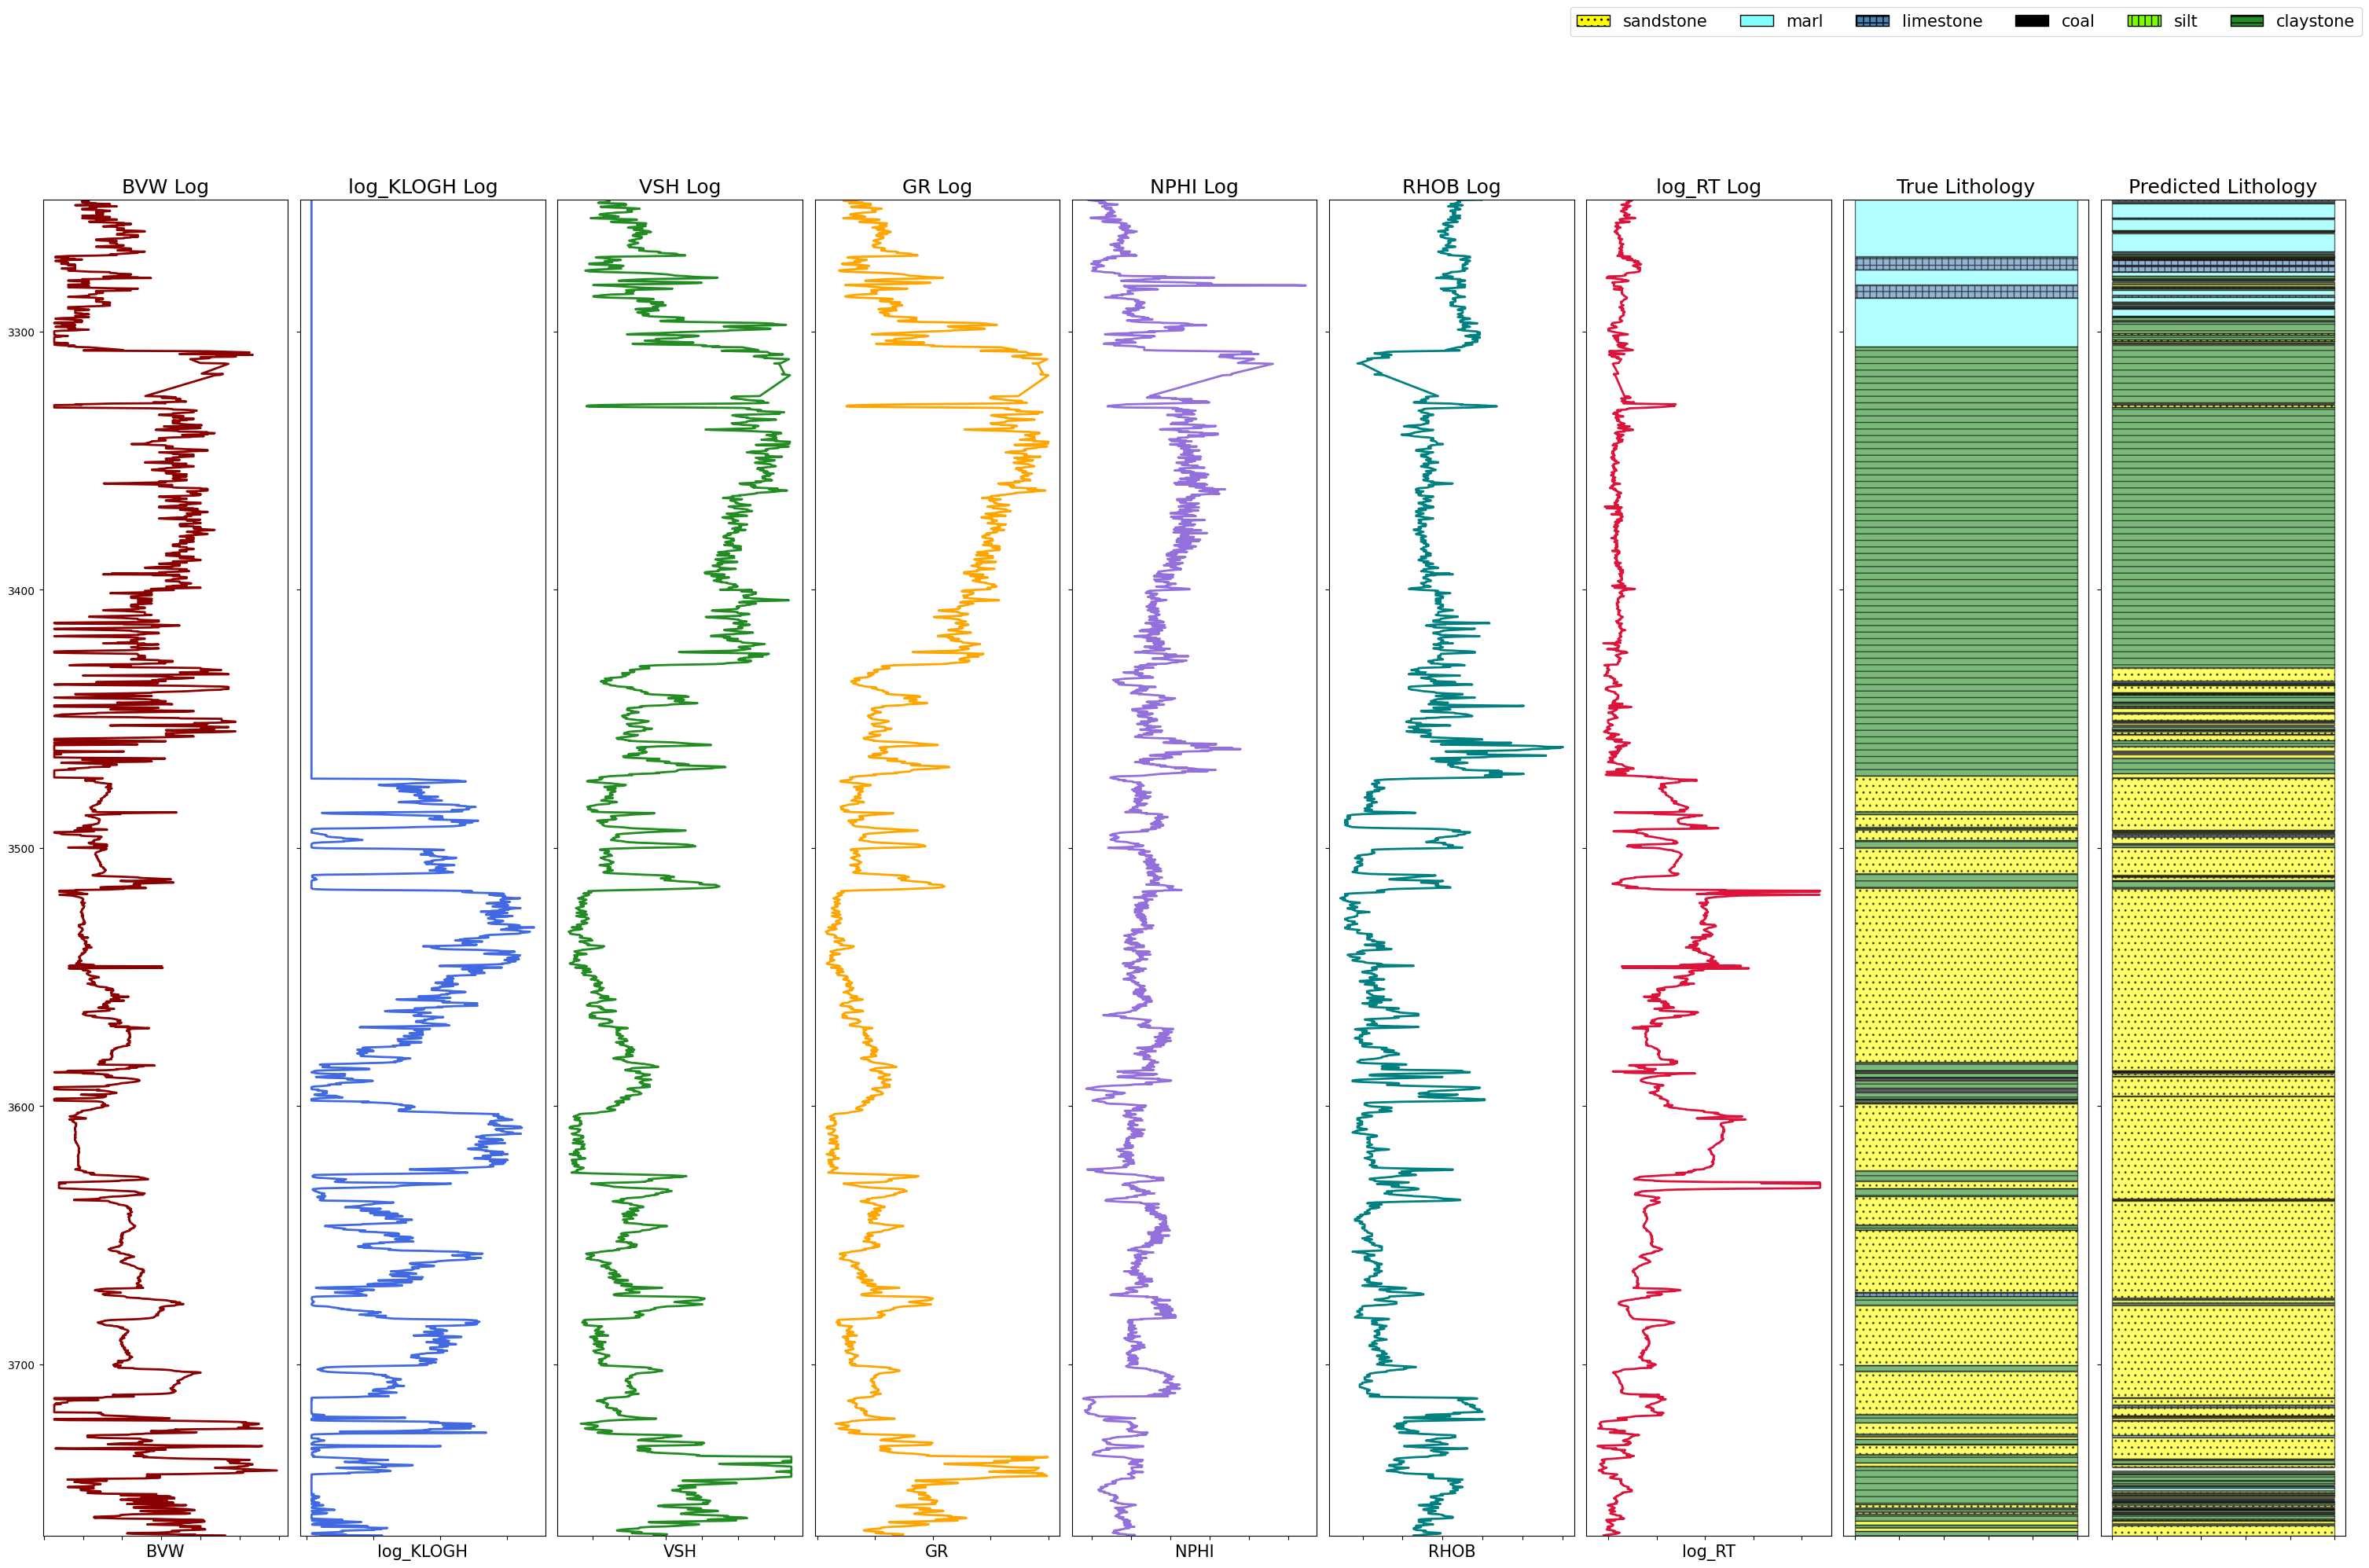

In [62]:
KNNClassifier.plot_lithology_comparison(scaled_test_well_data[0], test_RF_predicted_lithology0, use_hatch=True, log_columns=feature_columns)

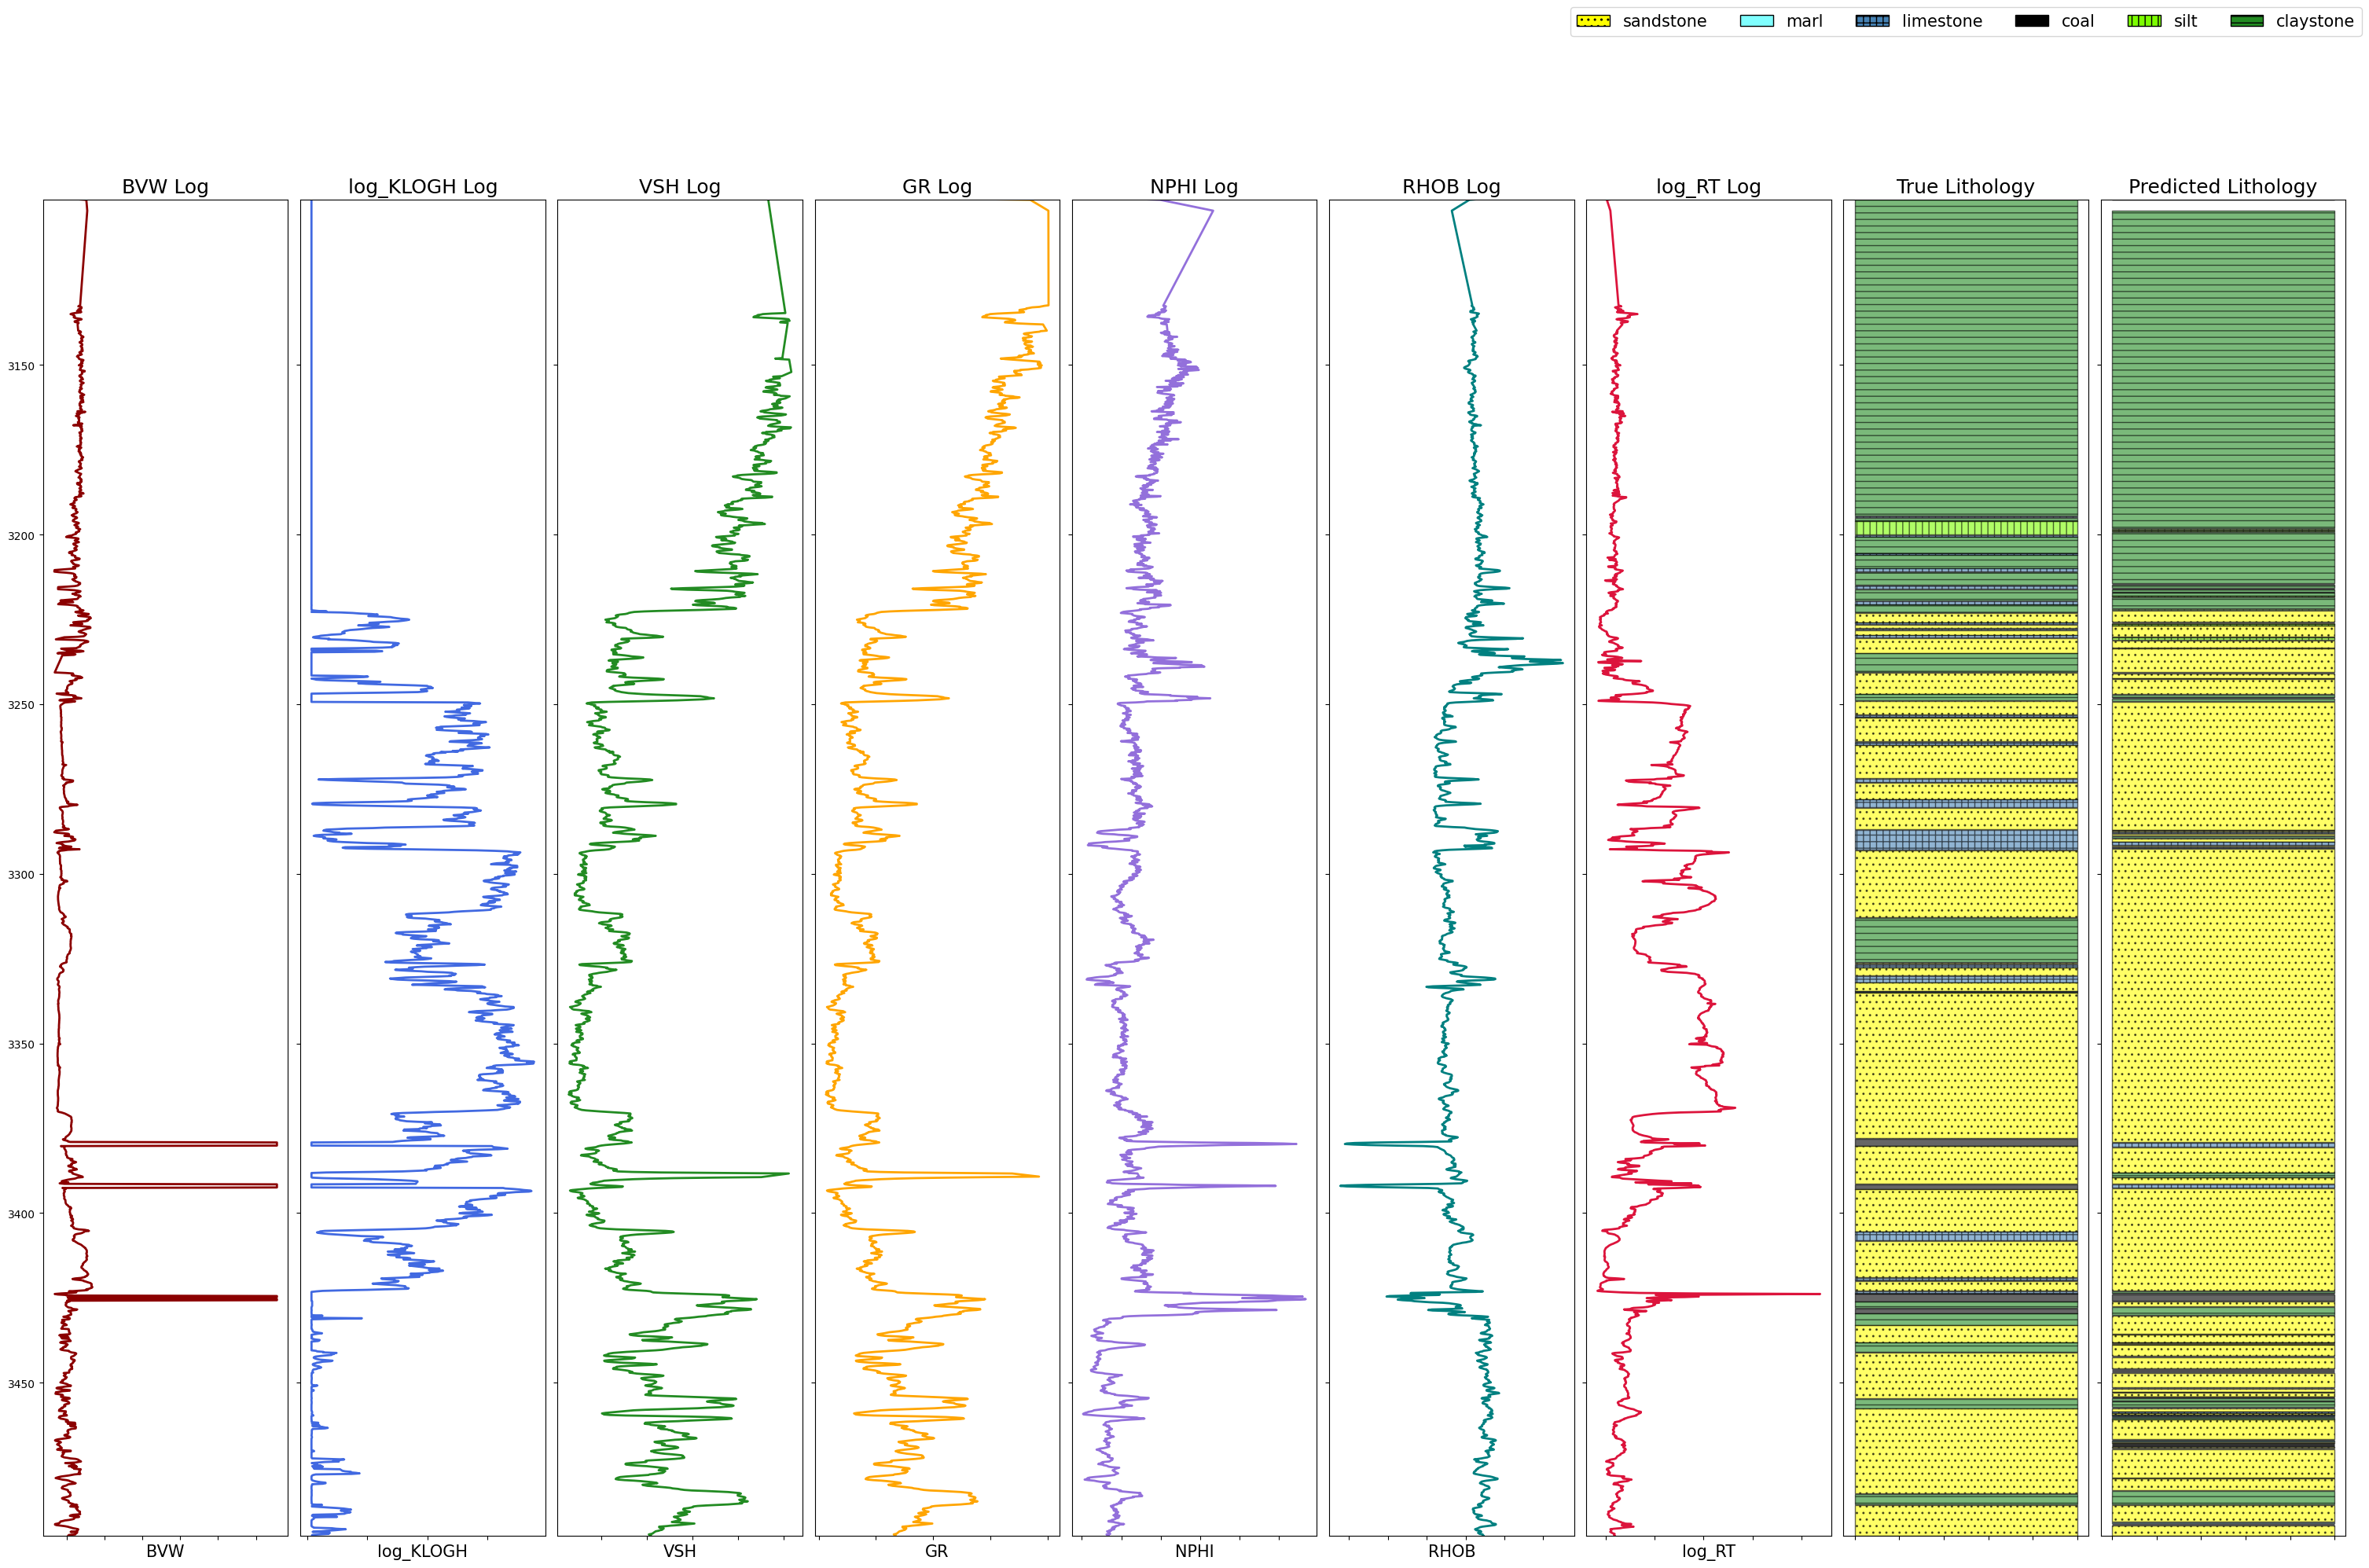

In [63]:
KNNClassifier.plot_lithology_comparison(scaled_test_well_data[1], test_RF_predicted_lithology1, use_hatch=True, log_columns=feature_columns)